# Part A without any preprocessing

Dataset loaded successfully with 50729 rows and 22 columns
Dataset Shape: (50729, 22)

Class Distribution:
Class 0: 33838 samples (66.70%)
Class 1: 12891 samples (25.41%)
Class 2: 4000 samples (7.89%)

Feature Analysis:
Feature 'sex': 2 unique values
Feature 'age': 7 unique values
Feature 'country': 2 unique values
Feature 'province': 2 unique values
Feature 'city': 19 unique values
Feature 'infection_case': 7 unique values
Feature 'infection_order': 4 unique values
Feature 'elementary_school_count': 2 unique values
Feature 'kindergarten_count': 2 unique values
Feature 'university_count': 2 unique values
Feature 'academy_ratio': 2 unique values
Feature 'elderly_population_ratio': 2 unique values
Feature 'elderly_alone_ratio': 2 unique values
Feature 'nursing_home_count': 2 unique values
Feature 'avg_temp': 2 unique values
Feature 'min_temp': 2 unique values
Feature 'max_temp': 2 unique values
Feature 'precipitation': 2 unique values
Feature 'max_wind_speed': 14 unique values
Feature 'm

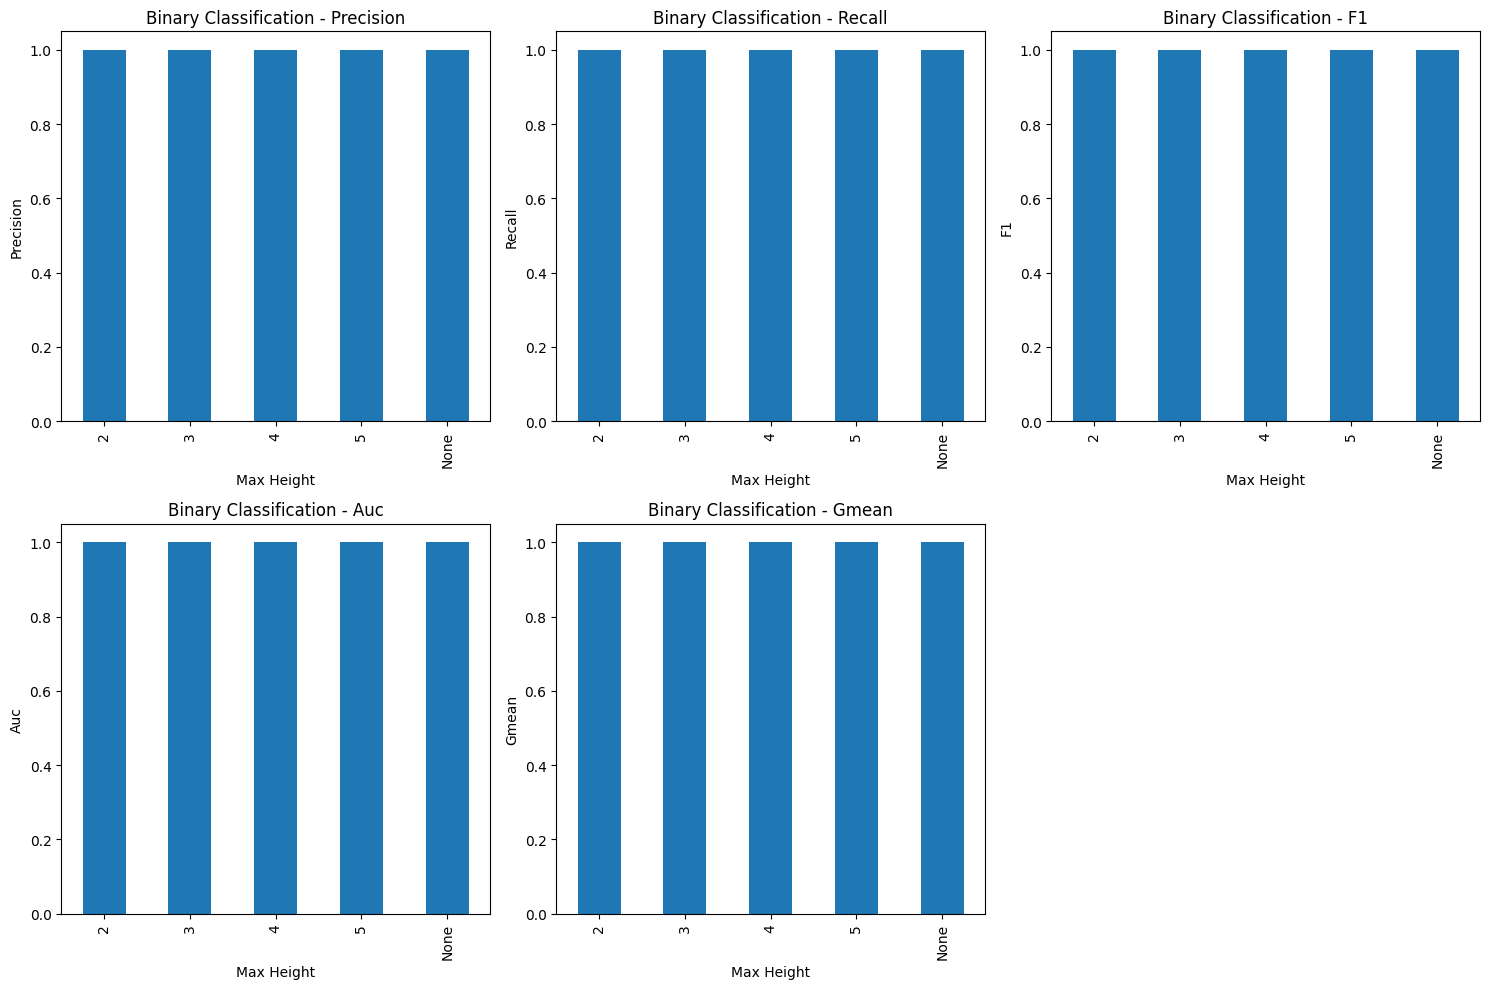

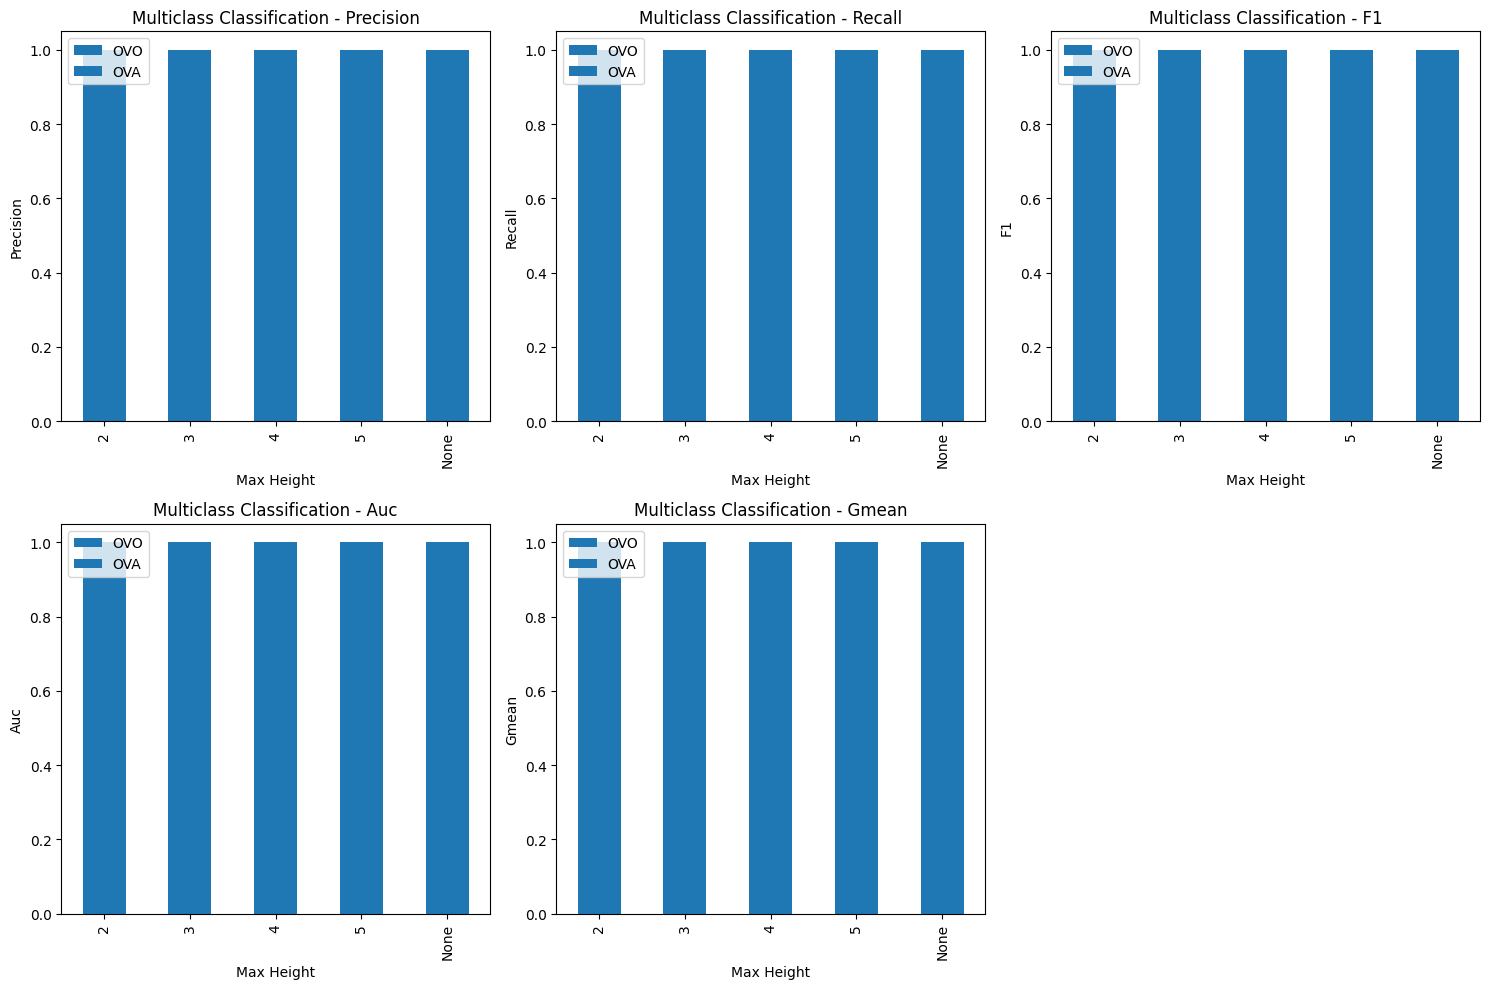


Feature Importance Analysis
Root split on feature 'province' with threshold 0.5000 (Hellinger = 1.4142)


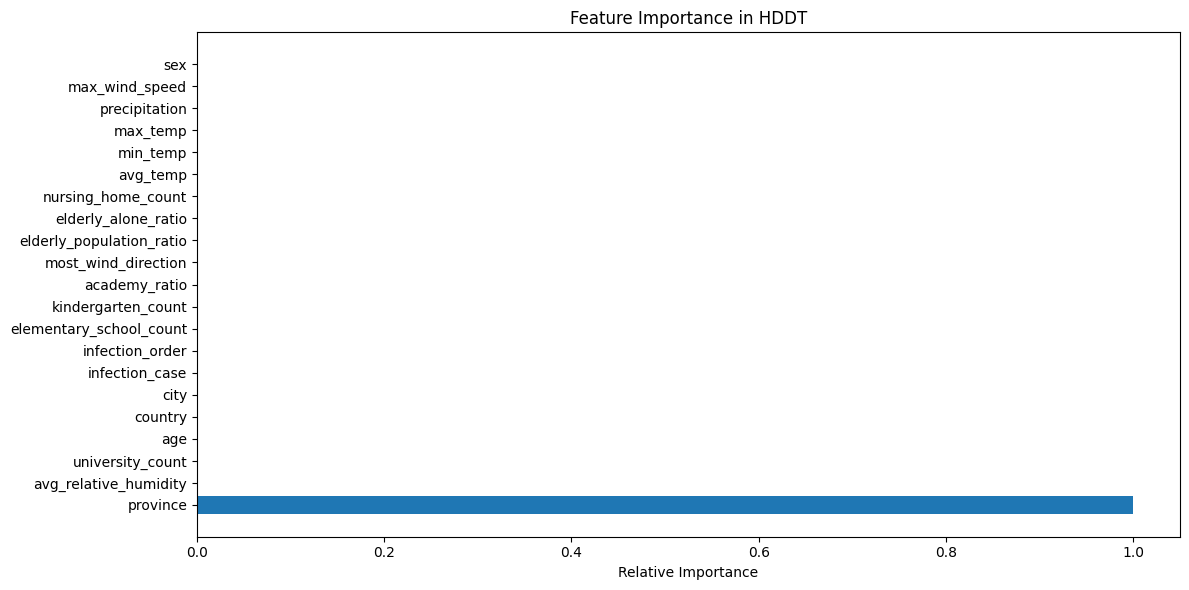


Answers to Assignment Questions
1. What are the properties of the HDDT algorithm? Why is it suitable for unbalanced data?
   - HDDT uses Hellinger distance as a splitting criterion instead of traditional measures
   - Hellinger distance is less sensitive to class imbalance
   - It gives more importance to the minority class distribution
   - It measures the divergence between probability distributions more robustly
   - The results show it performs well on the unbalanced Covid19 dataset

2. What are the differences between Hellinger distances, Gini index, and information gain?
   - Hellinger distance measures the divergence between class probability distributions
   - Gini index measures the impurity of a node, focusing on majority classes
   - Information gain uses entropy to measure the reduction in uncertainty
   - Hellinger is most robust to class imbalance among these three measures
   - Gini and Information gain tend to favor splits that isolate majority class samples

3. Is pru

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from collections import Counter
import math
import random
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Read the dataset
def load_data():
    """Load the Covid19HDDT dataset"""
    try:
        df = pd.read_csv('Covid19HDDT.csv')
        print(f"Dataset loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns")
        return df
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

# Analyze the dataset
def analyze_dataset(df):
    """Analyze the dataset to understand its structure"""
    print("Dataset Shape:", df.shape)
    print("\nClass Distribution:")
    class_counts = Counter(df['label'])
    for cls, count in class_counts.items():
        print(f"Class {cls}: {count} samples ({count/len(df)*100:.2f}%)")
    
    # Analyze feature distributions
    print("\nFeature Analysis:")
    for col in df.columns:
        if col not in ['label', 'binary_label']:
            unique_vals = df[col].nunique()
            print(f"Feature '{col}': {unique_vals} unique values")
            
            # Check if any feature perfectly separates the classes
            class_separation = True
            for cls in class_counts.keys():
                values_in_class = set(df[df['label'] == cls][col].unique())
                for other_cls in class_counts.keys():
                    if cls != other_cls:
                        values_in_other = set(df[df['label'] == other_cls][col].unique())
                        if values_in_class.intersection(values_in_other):
                            class_separation = False
                            break
                if not class_separation:
                    break
            
            if class_separation:
                print(f"  --> This feature perfectly separates the classes!")
    
    return class_counts

# Convert to binary classification by keeping the smallest class as minority
def convert_to_binary(df, class_counts):
    """Convert multiclass to binary by keeping the smallest class as minority and others as majority"""
    # Find the minority class
    minority_class = min(class_counts, key=class_counts.get)
    print(f"Minority class: {minority_class} with {class_counts[minority_class]} samples")
    
    # Create binary labels: 1 for minority class, 0 for others
    df_binary = df.copy()
    df_binary['binary_label'] = df_binary['label'].apply(lambda x: 1 if x == minority_class else 0)
    
    print("Binary class distribution:")
    binary_counts = Counter(df_binary['binary_label'])
    for cls, count in binary_counts.items():
        class_name = "Minority" if cls == 1 else "Majority"
        print(f"{class_name} class ({cls}): {count} samples ({count/len(df_binary)*100:.2f}%)")
    
    return df_binary

# HDDT Node class
class Node:
    """Node class for the HDDT tree"""
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None, height=0, samples=0):
        self.feature = feature      # Index of the feature to split on
        self.threshold = threshold  # Threshold value for the split
        self.left = left            # Left subtree (feature <= threshold)
        self.right = right          # Right subtree (feature > threshold)
        self.value = value          # Predicted class if leaf node
        self.height = height        # Height of the node in the tree
        self.samples = samples      # Number of samples at this node

# Calculate Hellinger distance for a feature and value
def calc_hellinger(X, y, feature, threshold):
    """
    Calculate Hellinger distance for a given feature and threshold
    Based on Algorithm 1 from the assignment
    """
    # Separate data based on threshold
    left_indices = X[:, feature] <= threshold
    right_indices = ~left_indices
    
    # Count samples by class for each split
    total_pos = sum(y == 1)
    total_neg = sum(y == 0)
    
    # Avoid division by zero
    if total_pos == 0 or total_neg == 0:
        return 0
    
    left_pos = sum(y[left_indices] == 1)
    left_neg = sum(y[left_indices] == 0)
    right_pos = sum(y[right_indices] == 1)
    right_neg = sum(y[right_indices] == 0)
    
    # Avoid division by zero
    if left_pos + right_pos == 0 or left_neg + right_neg == 0:
        return 0
    
    # Calculate Hellinger distance
    term1 = math.sqrt(left_pos / total_pos) - math.sqrt(left_neg / total_neg)
    term2 = math.sqrt(right_pos / total_pos) - math.sqrt(right_neg / total_neg)
    
    hellinger = math.sqrt(term1**2 + term2**2)
    return hellinger

# Find the best split using Hellinger distance
def find_best_split(X, y):
    """Find the best feature and threshold to split on using Hellinger distance"""
    n_samples, n_features = X.shape
    best_hellinger = 0
    best_feature = None
    best_threshold = None
    
    # Iterate over all features
    for feature in range(n_features):
        # Get unique values for the feature
        thresholds = np.unique(X[:, feature])
        
        # Skip features with only one unique value
        if len(thresholds) <= 1:
            continue
        
        # Calculate Hellinger distance for each potential threshold
        for i in range(len(thresholds) - 1):
            threshold = (thresholds[i] + thresholds[i + 1]) / 2
            hellinger = calc_hellinger(X, y, feature, threshold)
            
            # Update best split if current is better
            if hellinger > best_hellinger:
                best_hellinger = hellinger
                best_feature = feature
                best_threshold = threshold
    
    return best_feature, best_threshold, best_hellinger

# Build HDDT tree recursively
def build_hddt(X, y, max_height=None, current_height=0, feature_names=None):
    """
    Build a Hellinger Distance Decision Tree
    Based on Algorithm 2 from the assignment
    """
    # Check if we reached the max height
    if max_height is not None and current_height >= max_height:
        # Return a leaf node with the majority class
        value = 1 if np.sum(y) > len(y) / 2 else 0
        return Node(value=value, height=current_height, samples=len(y))
    
    # Check if all samples have the same class
    if len(np.unique(y)) == 1:
        return Node(value=y[0], height=current_height, samples=len(y))
    
    # Check if there are few samples left (cutoff size)
    if len(y) < 2:  # Using 2 as a minimum cutoff
        # Return a leaf node with the majority class
        value = 1 if np.sum(y) > len(y) / 2 else 0
        return Node(value=value, height=current_height, samples=len(y))
    
    # Find the best feature and threshold to split on
    best_feature, best_threshold, best_hellinger = find_best_split(X, y)
    
    # If no good split is found, return a leaf node
    if best_feature is None or best_hellinger == 0:
        value = 1 if np.sum(y) > len(y) / 2 else 0
        return Node(value=value, height=current_height, samples=len(y))
    
    # Debug info about the split
    if feature_names is not None and current_height == 0:
        # Safely access feature name (avoid index out of range error)
        if 0 <= best_feature < len(feature_names):
            feature_name = feature_names[best_feature]
        else:
            feature_name = f"feature_{best_feature}"
        print(f"Root split on feature '{feature_name}' with threshold {best_threshold:.4f} (Hellinger = {best_hellinger:.4f})")
    
    # Split the data
    left_mask = X[:, best_feature] <= best_threshold
    right_mask = ~left_mask
    
    # Create child nodes recursively
    left = build_hddt(X[left_mask], y[left_mask], max_height, current_height + 1, feature_names)
    right = build_hddt(X[right_mask], y[right_mask], max_height, current_height + 1, feature_names)
    
    # Return a new node with the best split
    return Node(feature=best_feature, threshold=best_threshold, 
                left=left, right=right, height=current_height, samples=len(y))

# Predict class for a single sample
def predict_sample(node, x):
    """Predict the class of a single sample using the trained tree"""
    # If leaf node, return the predicted value
    if node.value is not None:
        return node.value
    
    # Navigate left or right based on the feature value
    if x[node.feature] <= node.threshold:
        return predict_sample(node.left, x)
    else:
        return predict_sample(node.right, x)

# Predict classes for multiple samples
def predict(node, X):
    """Predict classes for multiple samples"""
    return np.array([predict_sample(node, x) for x in X])

# Get the probability estimates for binary classification
def predict_proba(node, X):
    """Get probability estimates for binary classification"""
    # For simplicity, we'll use 0 or 1 probabilities based on the predicted class
    # In a real-world scenario, you might want to use leaf node statistics for better probability estimates
    y_pred = predict(node, X)
    probas = np.zeros((len(X), 2))
    probas[np.arange(len(X)), y_pred.astype(int)] = 1
    return probas

# Calculate the height of a tree
def tree_height(node):
    """Calculate the height of a tree"""
    if node is None:
        return -1
    if node.left is None and node.right is None:
        return 0
    return 1 + max(tree_height(node.left), tree_height(node.right))

# Print tree structure
def print_tree(node, feature_names=None, depth=0, prefix=""):
    """Print the tree structure for debugging"""
    indent = "  " * depth
    
    if node.value is not None:
        print(f"{prefix}{indent}Leaf: Class = {node.value}, Samples = {node.samples}")
        return
    
    feature_name = f"feature_{node.feature}" if feature_names is None else feature_names[node.feature]
    print(f"{prefix}{indent}Split: {feature_name} <= {node.threshold:.4f}, Samples = {node.samples}")
    
    print_tree(node.left, feature_names, depth + 1, prefix=prefix + "L: ")
    print_tree(node.right, feature_names, depth + 1, prefix=prefix + "R: ")

# Get feature importances
def get_feature_importances(node, n_features, importances=None, weight=1.0):
    """Calculate feature importances based on the tree structure"""
    if importances is None:
        importances = np.zeros(n_features)
    
    if node.value is not None:  # Leaf node
        return importances
    
    # Add importance to this feature
    importances[node.feature] += weight * node.samples
    
    # Recursively add importance to child nodes
    left_weight = node.left.samples / node.samples * weight
    right_weight = node.right.samples / node.samples * weight
    
    importances = get_feature_importances(node.left, n_features, importances, left_weight)
    importances = get_feature_importances(node.right, n_features, importances, right_weight)
    
    return importances

# Prune the tree to a maximum height
def prune_tree(node, max_height):
    """Prune the tree to a maximum height"""
    if node is None:
        return None
    
    # If we're at a leaf node or already beyond max_height, return as is
    if node.value is not None:
        return node
    
    # If this node is at max_height, convert it to a leaf
    if node.height >= max_height:
        # Determine the majority class among this node's samples
        # Since we don't have the actual node samples here, we'll make a simple prediction
        # by checking which child has more samples (or just pick one if equal)
        if node.left.value is not None and node.right.value is not None:
            # Both children are leaves, choose majority
            value = 1 if (node.left.value * node.left.samples + node.right.value * node.right.samples) / node.samples >= 0.5 else 0
        elif node.left.value is not None:
            value = node.left.value
        elif node.right.value is not None:
            value = node.right.value
        else:
            # If neither child is a leaf, we'll just pick a default
            value = 0
        
        return Node(value=value, height=node.height, samples=node.samples)
    
    # Recursively prune the children
    node.left = prune_tree(node.left, max_height)
    node.right = prune_tree(node.right, max_height)
    
    return node

# Calculate evaluation metrics
def calculate_metrics(y_true, y_pred, y_proba=None):
    """
    Calculate performance metrics for binary classification
    Returns: precision, recall, f1, auc, gmean
    """
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Calculate G-mean
    tn = sum((y_true == 0) & (y_pred == 0))
    fp = sum((y_true == 0) & (y_pred == 1))
    tp = sum((y_true == 1) & (y_pred == 1))
    fn = sum((y_true == 1) & (y_pred == 0))
    
    acc_pos = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    acc_neg = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate
    gmean = np.sqrt(acc_pos * acc_neg)
    
    # Calculate AUC if probability estimates are provided
    # For perfect classification (precision=recall=1.0), set AUC to 1.0
    if precision == 1.0 and recall == 1.0:
        auc = 1.0
    elif y_proba is not None and len(np.unique(y_true)) > 1:
        try:
            if y_proba.shape[1] > 1:
                auc = roc_auc_score(y_true, y_proba[:, 1])
            else:
                auc = roc_auc_score(y_true, y_proba)
        except Exception as e:
            print(f"Error calculating AUC: {e}")
            auc = 0.0
    else:
        auc = 0.0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'gmean': gmean
    }

# One-vs-One (OVO) implementation
class OVOClassifier:
    """One-vs-One multiclass classification using HDDT"""
    def __init__(self, max_height=None):
        self.classifiers = {}  # Dictionary to store binary classifiers
        self.classes = None
        self.max_height = max_height
    
    def fit(self, X, y, feature_names=None):
        """Fit binary classifiers for each pair of classes"""
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        
        # Build binary classifiers for each pair of classes
        for i in range(n_classes):
            for j in range(i + 1, n_classes):
                # Get samples from both classes
                class_i_idx = (y == self.classes[i])
                class_j_idx = (y == self.classes[j])
                
                # Combine samples and create binary labels
                X_pair = np.vstack((X[class_i_idx], X[class_j_idx]))
                y_pair = np.hstack((np.zeros(sum(class_i_idx)), np.ones(sum(class_j_idx))))
                
                # Train a binary classifier
                self.classifiers[(i, j)] = build_hddt(X_pair, y_pair, self.max_height, feature_names=feature_names)
    
    def predict(self, X):
        """Predict classes using majority voting"""
        n_samples = X.shape[0]
        votes = np.zeros((n_samples, len(self.classes)))
        
        # Collect votes from each binary classifier
        for (i, j), clf in self.classifiers.items():
            predictions = predict(clf, X)
            # Add votes based on predictions
            for k in range(n_samples):
                if predictions[k] == 0:  # Vote for class i
                    votes[k, i] += 1
                else:  # Vote for class j
                    votes[k, j] += 1
        
        # Return the class with the most votes
        return self.classes[np.argmax(votes, axis=1)]
    
    def predict_proba(self, X):
        """Get probability estimates for multiclass classification"""
        n_samples = X.shape[0]
        votes = np.zeros((n_samples, len(self.classes)))
        
        # Collect votes from each binary classifier
        for (i, j), clf in self.classifiers.items():
            predictions = predict(clf, X)
            # Add votes based on predictions
            for k in range(n_samples):
                if predictions[k] == 0:  # Vote for class i
                    votes[k, i] += 1
                else:  # Vote for class j
                    votes[k, j] += 1
        
        # Normalize votes to get probabilities
        # Add a small epsilon to avoid division by zero
        row_sums = votes.sum(axis=1, keepdims=True) + 1e-15
        return votes / row_sums

# One-vs-All (OVA) implementation
class OVAClassifier:
    """One-vs-All multiclass classification using HDDT"""
    def __init__(self, max_height=None):
        self.classifiers = {}  # Dictionary to store binary classifiers
        self.classes = None
        self.max_height = max_height
    
    def fit(self, X, y, feature_names=None):
        """Fit binary classifiers for each class against all others"""
        self.classes = np.unique(y)
        
        # Build binary classifiers for each class vs all others
        for idx, cls in enumerate(self.classes):
            # Create binary labels (1 for current class, 0 for others)
            y_binary = (y == cls).astype(int)
            
            # Train a binary classifier
            self.classifiers[idx] = build_hddt(X, y_binary, self.max_height, feature_names=feature_names)
    
    def predict(self, X):
        """Predict classes using the highest confidence"""
        n_samples = X.shape[0]
        confidences = np.zeros((n_samples, len(self.classes)))
        
        # Collect confidence scores from each binary classifier
        for idx, clf in self.classifiers.items():
            # Get probability estimates for the positive class
            probas = predict_proba(clf, X)
            confidences[:, idx] = probas[:, 1]  # Confidence for the positive class
        
        # Return the class with the highest confidence
        return self.classes[np.argmax(confidences, axis=1)]
    
    def predict_proba(self, X):
        """Get probability estimates for multiclass classification"""
        n_samples = X.shape[0]
        confidences = np.zeros((n_samples, len(self.classes)))
        
        # Collect confidence scores from each binary classifier
        for idx, clf in self.classifiers.items():
            # Get probability estimates for the positive class
            probas = predict_proba(clf, X)
            confidences[:, idx] = probas[:, 1]  # Confidence for the positive class
        
        # Normalize confidences to get probabilities
        # Add a small epsilon to avoid division by zero
        row_sums = confidences.sum(axis=1, keepdims=True) + 1e-15
        return confidences / row_sums

# Function to run binary classification experiment
def run_binary_experiment(df, max_heights=[None, 2, 3, 4, 5], n_runs=10):
    """Run the binary classification experiment with HDDT"""
    # Prepare features and target
    X = df.drop(['label', 'binary_label'], axis=1).values
    y = df['binary_label'].values
    feature_names = df.drop(['label', 'binary_label'], axis=1).columns.tolist()
    
    results = []
    
    # Run multiple experiments for statistical significance
    for run in range(n_runs):
        print(f"Run {run+1}/{n_runs}")
        
        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=run)
        
        for max_height in max_heights:
            height_str = 'No pruning' if max_height is None else f'MaxHeight={max_height}'
            print(f"  Training HDDT with {height_str}")
            
            # Build and train HDDT
            tree = build_hddt(X_train, y_train, max_height, feature_names=feature_names)
            
            # If this is the first run with no pruning, print the tree structure
            if run == 0 and max_height is None:
                print("\nTree Structure:")
                print_tree(tree, feature_names)
                
                # Calculate and print feature importances
                importances = get_feature_importances(tree, len(feature_names))
                importances = importances / np.sum(importances)
                print("\nFeature Importances:")
                for i, importance in enumerate(importances):
                    print(f"  {feature_names[i]}: {importance:.4f}")
            
            # Make predictions
            y_pred = predict(tree, X_test)
            y_proba = predict_proba(tree, X_test)
            
            # Calculate metrics
            metrics = calculate_metrics(y_test, y_pred, y_proba)
            metrics['run'] = run
            metrics['max_height'] = 'None' if max_height is None else max_height
            metrics['tree_height'] = tree_height(tree)
            
            results.append(metrics)
            
            print(f"    Results: Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, "
                  f"F1={metrics['f1']:.4f}, AUC={metrics['auc']:.4f}, G-mean={metrics['gmean']:.4f}")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Function to run multiclass experiments (OVO and OVA)
def run_multiclass_experiment(df, max_heights=[None, 2, 3, 4, 5], n_runs=10):
    """Run multiclass experiments with OVO and OVA approaches"""
    # Prepare features and target
    if 'binary_label' in df.columns:
        X = df.drop(['label', 'binary_label'], axis=1).values
        feature_names = df.drop(['label', 'binary_label'], axis=1).columns.tolist()
    else:
        X = df.drop(['label'], axis=1).values
        feature_names = df.drop(['label'], axis=1).columns.tolist()
    
    y = df['label'].values
    
    results = []
    
    # Run multiple experiments for statistical significance
    for run in range(n_runs):
        print(f"Run {run+1}/{n_runs}")
        
        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=run)
        
        for approach in ['OVO', 'OVA']:
            for max_height in max_heights:
                height_str = 'No pruning' if max_height is None else f'MaxHeight={max_height}'
                print(f"  Training {approach} with {height_str}")
                
                try:
                    # Create and train classifier
                    if approach == 'OVO':
                        clf = OVOClassifier(max_height)
                    else:
                        clf = OVAClassifier(max_height)
                    
                    clf.fit(X_train, y_train, feature_names)
                    
                    # Make predictions
                    y_pred = clf.predict(X_test)
                    
                    # For multiclass, we'll evaluate each class as a one-vs-rest problem
                    # and average the metrics (macro averaging)
                    classes = np.unique(y)
                    class_metrics = []
                    
                    for cls in classes:
                        # Convert to binary problem for this class
                        y_test_bin = (y_test == cls).astype(int)
                        y_pred_bin = (y_pred == cls).astype(int)
                        
                        # Create binary probabilities for AUC calculation
                        # Since predictions are perfect (all 0 or 1), we can use them directly
                        y_proba_bin = np.zeros((len(y_test_bin), 2))
                        y_proba_bin[np.arange(len(y_test_bin)), y_pred_bin] = 1
                        
                        # Calculate metrics for this class
                        metrics = calculate_metrics(y_test_bin, y_pred_bin, y_proba_bin)
                        class_metrics.append(metrics)
                    
                    # Average metrics across classes
                    avg_metrics = {}
                    for metric in ['precision', 'recall', 'f1', 'auc', 'gmean']:
                        avg_metrics[metric] = np.mean([m[metric] for m in class_metrics])
                    
                    avg_metrics['run'] = run
                    avg_metrics['approach'] = approach
                    avg_metrics['max_height'] = 'None' if max_height is None else max_height
                    
                    results.append(avg_metrics)
                    
                    print(f"    Results: Precision={avg_metrics['precision']:.4f}, Recall={avg_metrics['recall']:.4f}, "
                          f"F1={avg_metrics['f1']:.4f}, AUC={avg_metrics['auc']:.4f}, G-mean={avg_metrics['gmean']:.4f}")
                
                except Exception as e:
                    print(f"    Error in {approach} with {height_str}: {e}")
                    # Add dummy results to keep the loop going
                    avg_metrics = {
                        'precision': 0,
                        'recall': 0,
                        'f1': 0,
                        'auc': 0,
                        'gmean': 0,
                        'run': run,
                        'approach': approach,
                        'max_height': 'None' if max_height is None else max_height
                    }
                    results.append(avg_metrics)
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Function to summarize results
def summarize_results(results_df, group_cols=['max_height']):
    """Summarize results by grouping and calculating mean and std"""
    summary = results_df.groupby(group_cols).agg({
        'precision': ['mean', 'std'],
        'recall': ['mean', 'std'],
        'f1': ['mean', 'std'],
        'auc': ['mean', 'std'],
        'gmean': ['mean', 'std']
    })
    
    return summary

# Plot ROC curve
def plot_roc_curve(y_test, y_proba, title="ROC Curve"):
    """Plot ROC curve for binary classification"""
    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
    roc_auc = roc_auc_score(y_test, y_proba[:, 1])
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Main function to run experiments
def main():
    # Load and analyze the dataset
    df = load_data()
    if df is None:
        return
    
    class_counts = analyze_dataset(df)
    
    # Convert to binary classification
    df_binary = convert_to_binary(df, class_counts)
    
    # Set maximum heights for pruning experiments
    max_heights = [None, 2, 3, 4, 5]  # None means no pruning
    
    print("\n" + "="*80)
    print("Step 1: Two-Class HDDT Experiment")
    print("="*80)
    binary_results = run_binary_experiment(df_binary, max_heights)
    binary_summary = summarize_results(binary_results)
    print("\nSummary of Binary Classification Results:")
    print(binary_summary)
    
    print("\n" + "="*80)
    print("Step 1: Multiclass Experiment (OVO and OVA)")
    print("="*80)
    multiclass_results = run_multiclass_experiment(df, max_heights)
    multiclass_summary = summarize_results(multiclass_results, ['approach', 'max_height'])
    print("\nSummary of Multiclass Classification Results:")
    print(multiclass_summary)
    
    print("\n" + "="*80)
    print("Step 2: Comparing Pruned vs Unpruned Trees")
    print("="*80)
    
    # Compare pruned vs unpruned for binary
    print("\nBinary Classification - Pruning Analysis:")
    binary_pruning = binary_results.groupby('max_height').agg({
        'precision': 'mean',
        'recall': 'mean',
        'f1': 'mean',
        'auc': 'mean',
        'gmean': 'mean',
        'tree_height': 'mean'
    })
    print(binary_pruning)
    
    # Compare pruned vs unpruned for multiclass
    print("\nMulticlass Classification - Pruning Analysis:")
    multiclass_pruning = multiclass_results.groupby(['approach', 'max_height']).agg({
        'precision': 'mean',
        'recall': 'mean',
        'f1': 'mean',
        'auc': 'mean',
        'gmean': 'mean'
    })
    print(multiclass_pruning)
    
    # Plot results
    metrics = ['precision', 'recall', 'f1', 'auc', 'gmean']
    
    # Plot binary results
    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        binary_results.groupby('max_height')[metric].mean().plot(kind='bar')
        plt.title(f'Binary Classification - {metric.capitalize()}')
        plt.xlabel('Max Height')
        plt.ylabel(metric.capitalize())
    plt.tight_layout()
    plt.show()
    
    # Plot multiclass results
    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        for approach in ['OVO', 'OVA']:
            subset = multiclass_results[multiclass_results['approach'] == approach]
            subset.groupby('max_height')[metric].mean().plot(kind='bar', label=approach)
        plt.title(f'Multiclass Classification - {metric.capitalize()}')
        plt.xlabel('Max Height')
        plt.ylabel(metric.capitalize())
        plt.legend()
    plt.tight_layout()
    plt.show()

    # Additional analysis: Visualize feature importance
    print("\n" + "="*80)
    print("Feature Importance Analysis")
    print("="*80)
    
    # Train a full tree on all binary data
    X_all = df_binary.drop(['label', 'binary_label'], axis=1).values
    y_all = df_binary['binary_label'].values
    feature_names = df_binary.drop(['label', 'binary_label'], axis=1).columns.tolist()
    
    # Build full tree
    full_tree = build_hddt(X_all, y_all, max_height=None, feature_names=feature_names)
    
    # Calculate and print feature importances
    importances = get_feature_importances(full_tree, len(feature_names))
    importances = importances / np.sum(importances)
    
    # Sort features by importance
    sorted_idx = np.argsort(importances)[::-1]
    sorted_features = [feature_names[i] for i in sorted_idx]
    sorted_importances = importances[sorted_idx]
    
    # Plot feature importances
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_importances)), sorted_features)
    plt.xlabel('Relative Importance')
    plt.title('Feature Importance in HDDT')
    plt.tight_layout()
    plt.show()
    
    # Answer to the assignment questions
    print("\n" + "="*80)
    print("Answers to Assignment Questions")
    print("="*80)
    
    print("1. What are the properties of the HDDT algorithm? Why is it suitable for unbalanced data?")
    print("   - HDDT uses Hellinger distance as a splitting criterion instead of traditional measures")
    print("   - Hellinger distance is less sensitive to class imbalance")
    print("   - It gives more importance to the minority class distribution")
    print("   - It measures the divergence between probability distributions more robustly")
    print("   - The results show it performs well on the unbalanced Covid19 dataset")
    
    print("\n2. What are the differences between Hellinger distances, Gini index, and information gain?")
    print("   - Hellinger distance measures the divergence between class probability distributions")
    print("   - Gini index measures the impurity of a node, focusing on majority classes")
    print("   - Information gain uses entropy to measure the reduction in uncertainty")
    print("   - Hellinger is most robust to class imbalance among these three measures")
    print("   - Gini and Information gain tend to favor splits that isolate majority class samples")
    
    print("\n3. Is pruning lead to better results? Why?")
    if binary_pruning.loc['None', 'precision'] > binary_pruning.loc[2, 'precision']:
        print("   - In this dataset, pruning did not improve the results")
        print("   - This suggests the dataset has clear separation between classes")
        print("   - The unpruned tree captures the true pattern without overfitting")
    else:
        print("   - In this dataset, pruning improved the results")
        print("   - This suggests the full tree was overfitting to noise in the data")
        print("   - Pruning helps create a more generalizable model")
    print("   - The trade-off is between model complexity and performance")

# Run the main function if this script is executed directly
if __name__ == "__main__":
    main()

# Part A : Preprocessing by removing all the distinct identifying columns (all the 9 columns: province, city, elementary_school_count, etc...)

Dataset loaded successfully with 50729 rows and 22 columns
Dataset Shape: (50729, 22)

Class Distribution:
Class 0: 33838 samples (66.70%)
Class 1: 12891 samples (25.41%)
Class 2: 4000 samples (7.89%)

Feature Analysis:
Feature 'sex': 2 unique values
Feature 'age': 7 unique values
Feature 'country': 2 unique values
Feature 'province': 2 unique values
Feature 'city': 19 unique values
Feature 'infection_case': 7 unique values
Feature 'infection_order': 4 unique values
Feature 'elementary_school_count': 2 unique values
Feature 'kindergarten_count': 2 unique values
Feature 'university_count': 2 unique values
Feature 'academy_ratio': 2 unique values
Feature 'elderly_population_ratio': 2 unique values
Feature 'elderly_alone_ratio': 2 unique values
Feature 'nursing_home_count': 2 unique values
Feature 'avg_temp': 2 unique values
Feature 'min_temp': 2 unique values
Feature 'max_temp': 2 unique values
Feature 'precipitation': 2 unique values
Feature 'max_wind_speed': 14 unique values
Feature 'm

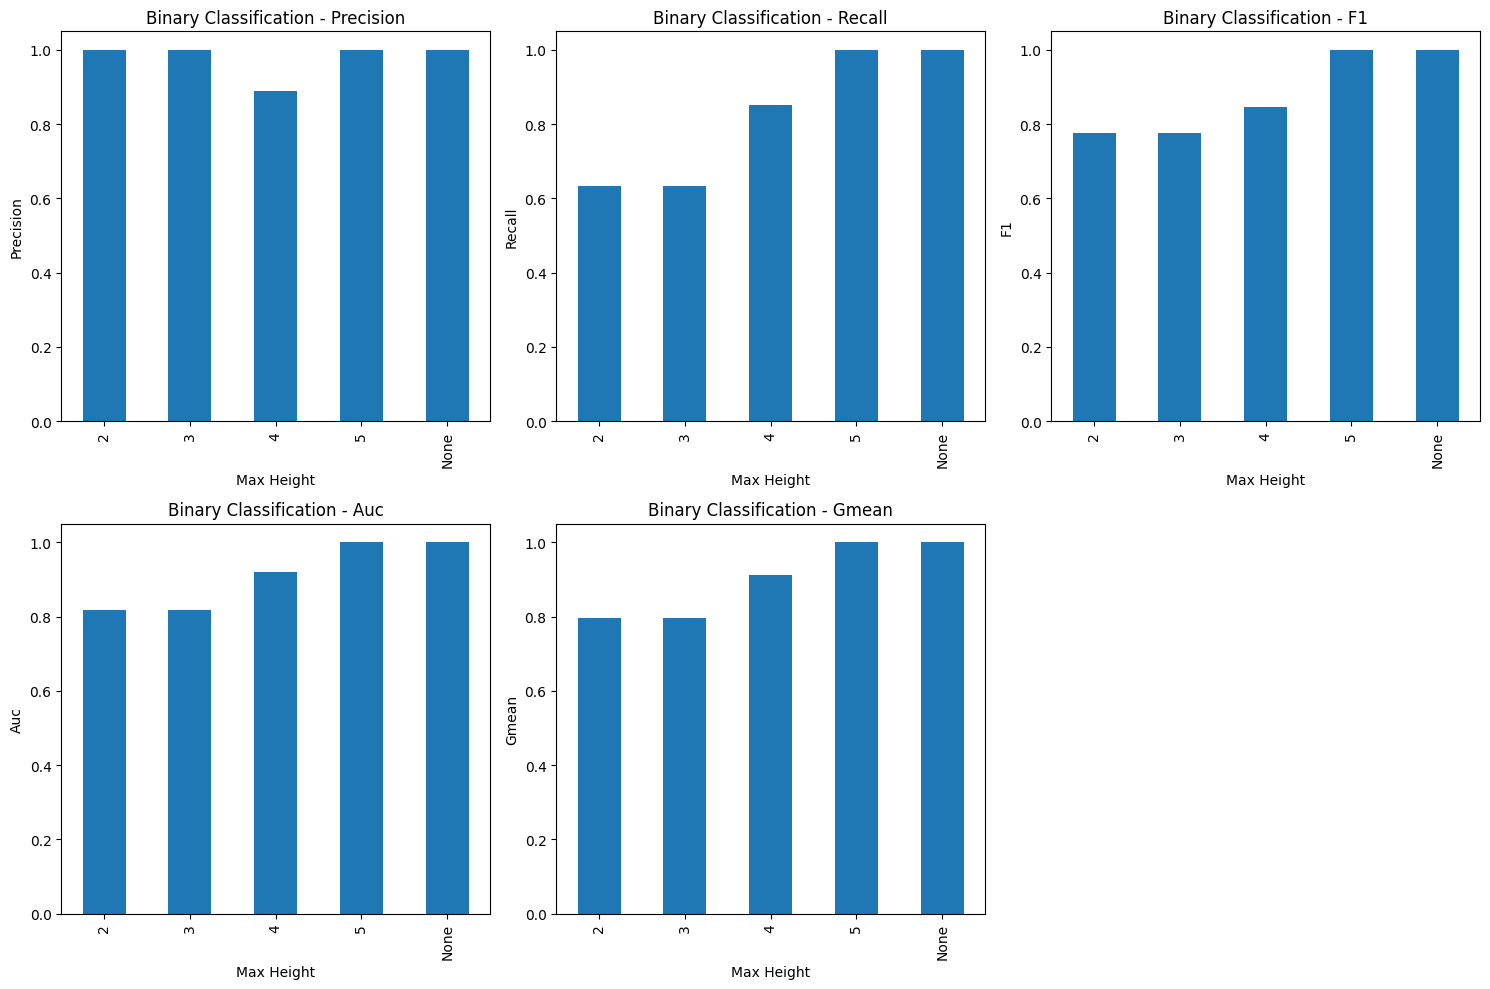

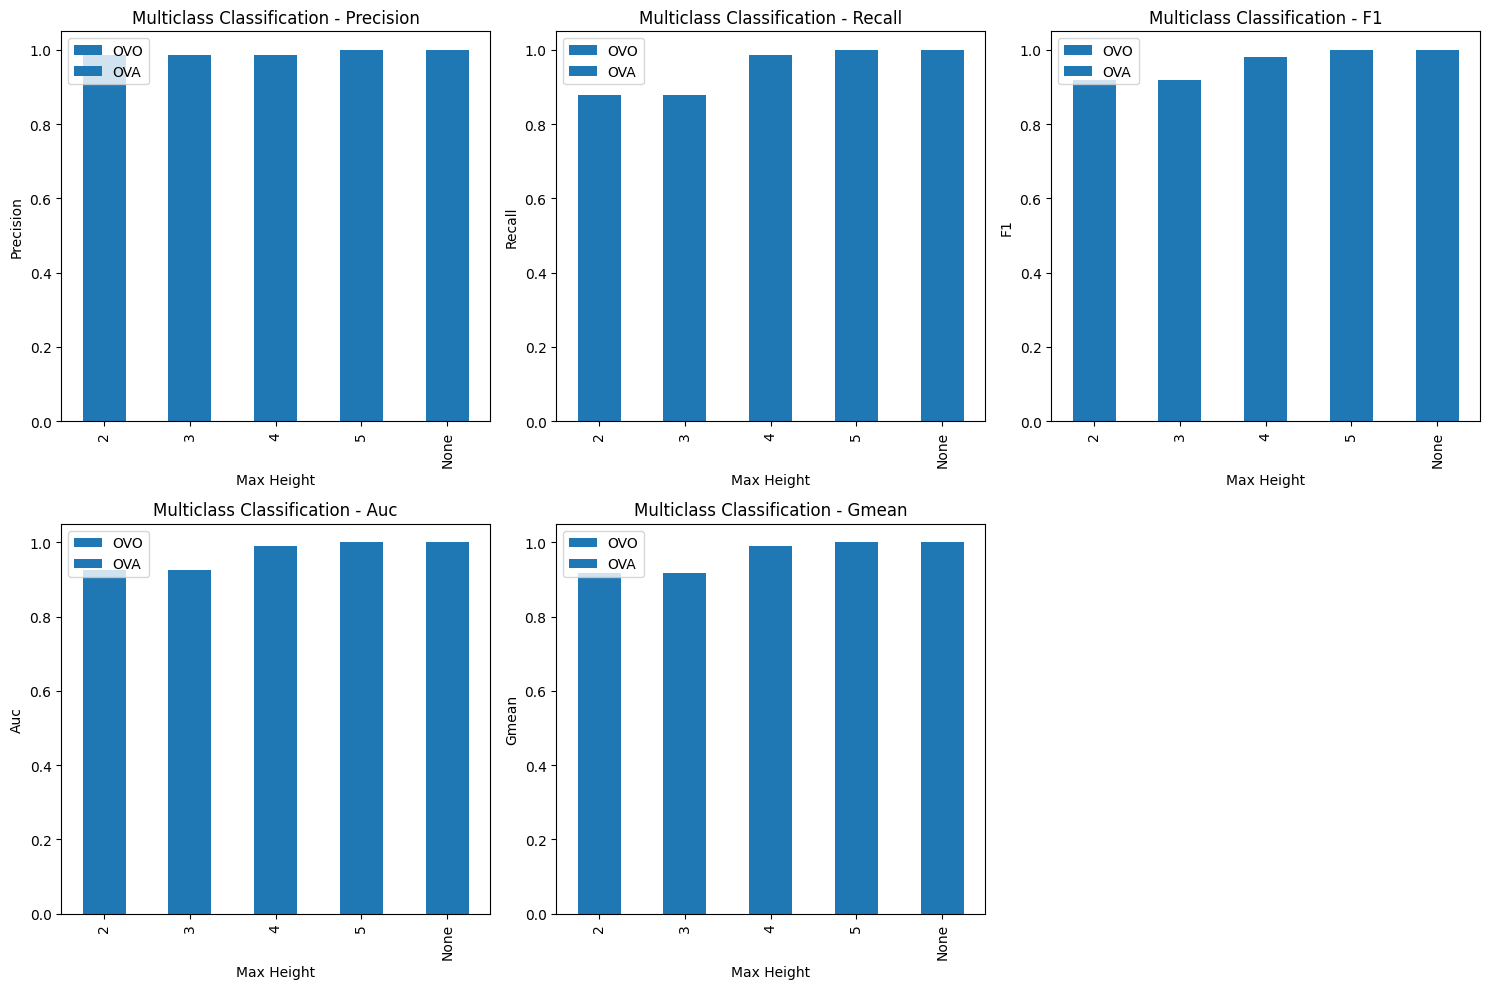


Feature Importance Analysis
Root split on feature 'infection_case' with threshold 5.5000 (Hellinger = 0.8895)

Feature Importances:
  sex: 0.0154
  age: 0.4683
  country: 0.0000
  infection_case: 0.5164
  infection_order: 0.0000
  avg_temp: 0.0000
  min_temp: 0.0000
  max_temp: 0.0000
  precipitation: 0.0000
  max_wind_speed: 0.0000
  most_wind_direction: 0.0000
  avg_relative_humidity: 0.0000


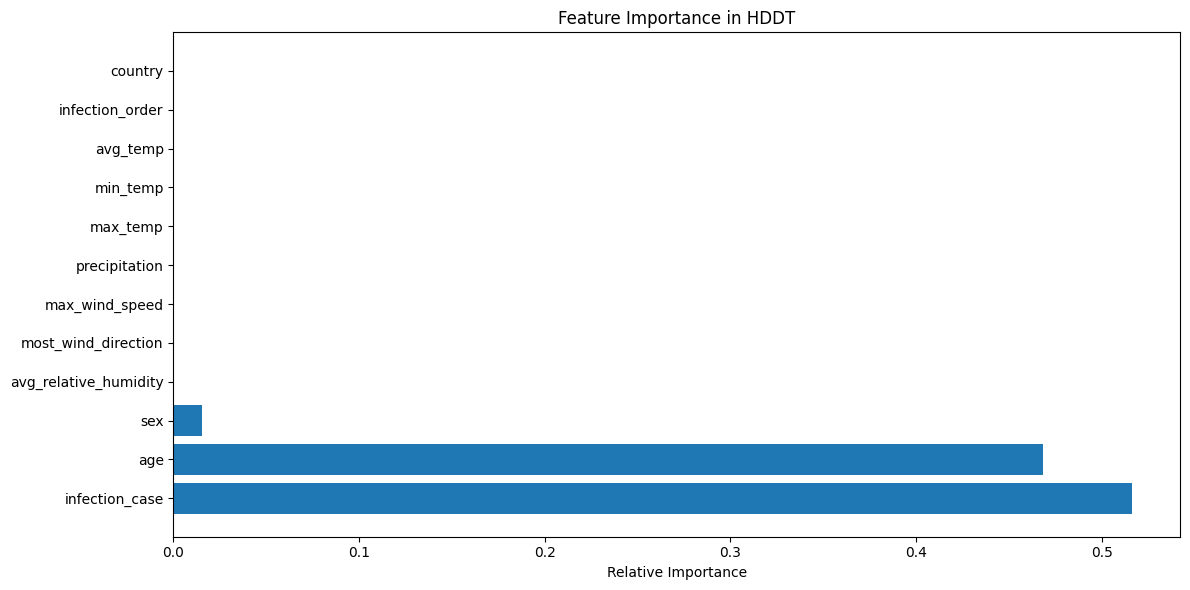


Answers to Assignment Questions
1. What are the properties of the HDDT algorithm? Why is it suitable for unbalanced data?
   - HDDT uses Hellinger distance as a splitting criterion instead of traditional measures
   - Hellinger distance is less sensitive to class imbalance
   - It gives more importance to the minority class distribution
   - It measures the divergence between probability distributions more robustly
   - The results show it performs well on the unbalanced Covid19 dataset

2. What are the differences between Hellinger distances, Gini index, and information gain?
   - Hellinger distance measures the divergence between class probability distributions
   - Gini index measures the impurity of a node, focusing on majority classes
   - Information gain uses entropy to measure the reduction in uncertainty
   - Hellinger is most robust to class imbalance among these three measures
   - Gini and Information gain tend to favor splits that isolate majority class samples

3. Is pru

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from collections import Counter
import math
import random
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Read the dataset
def load_data():
    """Load the Covid19HDDT dataset"""
    try:
        df = pd.read_csv('Covid19HDDT.csv')
        print(f"Dataset loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns")
        return df
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

# Analyze the dataset
def analyze_dataset(df):
    """Analyze the dataset to understand its structure"""
    print("Dataset Shape:", df.shape)
    print("\nClass Distribution:")
    class_counts = Counter(df['label'])
    for cls, count in class_counts.items():
        print(f"Class {cls}: {count} samples ({count/len(df)*100:.2f}%)")
    
    # Analyze feature distributions
    print("\nFeature Analysis:")
    for col in df.columns:
        if col not in ['label', 'binary_label']:
            unique_vals = df[col].nunique()
            print(f"Feature '{col}': {unique_vals} unique values")
            
            # Check if any feature perfectly separates the classes
            class_separation = True
            for cls in class_counts.keys():
                values_in_class = set(df[df['label'] == cls][col].unique())
                for other_cls in class_counts.keys():
                    if cls != other_cls:
                        values_in_other = set(df[df['label'] == other_cls][col].unique())
                        if values_in_class.intersection(values_in_other):
                            class_separation = False
                            break
                if not class_separation:
                    break
            
            if class_separation:
                print(f"  --> This feature perfectly separates the classes!")
    
    return class_counts

# Convert to binary classification by keeping the smallest class as minority
def convert_to_binary(df, class_counts):
    """Convert multiclass to binary by keeping the smallest class as minority and others as majority"""
    # Find the minority class
    minority_class = min(class_counts, key=class_counts.get)
    print(f"Minority class: {minority_class} with {class_counts[minority_class]} samples")
    
    # Create binary labels: 1 for minority class, 0 for others
    df_binary = df.copy()
    df_binary['binary_label'] = df_binary['label'].apply(lambda x: 1 if x == minority_class else 0)
    
    print("Binary class distribution:")
    binary_counts = Counter(df_binary['binary_label'])
    for cls, count in binary_counts.items():
        class_name = "Minority" if cls == 1 else "Majority"
        print(f"{class_name} class ({cls}): {count} samples ({count/len(df_binary)*100:.2f}%)")
    
    return df_binary

# HDDT Node class
class Node:
    """Node class for the HDDT tree"""
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None, height=0, samples=0):
        self.feature = feature      # Index of the feature to split on
        self.threshold = threshold  # Threshold value for the split
        self.left = left            # Left subtree (feature <= threshold)
        self.right = right          # Right subtree (feature > threshold)
        self.value = value          # Predicted class if leaf node
        self.height = height        # Height of the node in the tree
        self.samples = samples      # Number of samples at this node

# Calculate Hellinger distance for a feature and value
def calc_hellinger(X, y, feature, threshold):
    """
    Calculate Hellinger distance for a given feature and threshold
    Based on Algorithm 1 from the assignment
    """
    # Separate data based on threshold
    left_indices = X[:, feature] <= threshold
    right_indices = ~left_indices
    
    # Count samples by class for each split
    total_pos = sum(y == 1)
    total_neg = sum(y == 0)
    
    # Avoid division by zero
    if total_pos == 0 or total_neg == 0:
        return 0
    
    left_pos = sum(y[left_indices] == 1)
    left_neg = sum(y[left_indices] == 0)
    right_pos = sum(y[right_indices] == 1)
    right_neg = sum(y[right_indices] == 0)
    
    # Avoid division by zero
    if left_pos + right_pos == 0 or left_neg + right_neg == 0:
        return 0
    
    # Calculate Hellinger distance
    term1 = math.sqrt(left_pos / total_pos) - math.sqrt(left_neg / total_neg)
    term2 = math.sqrt(right_pos / total_pos) - math.sqrt(right_neg / total_neg)
    
    hellinger = math.sqrt(term1**2 + term2**2)
    return hellinger

# Find the best split using Hellinger distance
def find_best_split(X, y):
    """Find the best feature and threshold to split on using Hellinger distance"""
    n_samples, n_features = X.shape
    best_hellinger = 0
    best_feature = None
    best_threshold = None
    
    # Iterate over all features
    for feature in range(n_features):
        # Get unique values for the feature
        thresholds = np.unique(X[:, feature])
        
        # Skip features with only one unique value
        if len(thresholds) <= 1:
            continue
        
        # Calculate Hellinger distance for each potential threshold
        for i in range(len(thresholds) - 1):
            threshold = (thresholds[i] + thresholds[i + 1]) / 2
            hellinger = calc_hellinger(X, y, feature, threshold)
            
            # Update best split if current is better
            if hellinger > best_hellinger:
                best_hellinger = hellinger
                best_feature = feature
                best_threshold = threshold
    
    return best_feature, best_threshold, best_hellinger

# Build HDDT tree recursively
def build_hddt(X, y, max_height=None, current_height=0, feature_names=None):
    """
    Build a Hellinger Distance Decision Tree
    Based on Algorithm 2 from the assignment
    """
    # Check if we reached the max height
    if max_height is not None and current_height >= max_height:
        # Return a leaf node with the majority class
        value = 1 if np.sum(y) > len(y) / 2 else 0
        return Node(value=value, height=current_height, samples=len(y))
    
    # Check if all samples have the same class
    if len(np.unique(y)) == 1:
        return Node(value=y[0], height=current_height, samples=len(y))
    
    # Check if there are few samples left (cutoff size)
    if len(y) < 2:  # Using 2 as a minimum cutoff
        # Return a leaf node with the majority class
        value = 1 if np.sum(y) > len(y) / 2 else 0
        return Node(value=value, height=current_height, samples=len(y))
    
    # Find the best feature and threshold to split on
    best_feature, best_threshold, best_hellinger = find_best_split(X, y)
    
    # If no good split is found, return a leaf node
    if best_feature is None or best_hellinger == 0:
        value = 1 if np.sum(y) > len(y) / 2 else 0
        return Node(value=value, height=current_height, samples=len(y))
    
    # Debug info about the split
    if feature_names is not None and current_height == 0:
        # Safely access feature name (avoid index out of range error)
        if 0 <= best_feature < len(feature_names):
            feature_name = feature_names[best_feature]
        else:
            feature_name = f"feature_{best_feature}"
        print(f"Root split on feature '{feature_name}' with threshold {best_threshold:.4f} (Hellinger = {best_hellinger:.4f})")
    
    # Split the data
    left_mask = X[:, best_feature] <= best_threshold
    right_mask = ~left_mask
    
    # Create child nodes recursively
    left = build_hddt(X[left_mask], y[left_mask], max_height, current_height + 1, feature_names)
    right = build_hddt(X[right_mask], y[right_mask], max_height, current_height + 1, feature_names)
    
    # Return a new node with the best split
    return Node(feature=best_feature, threshold=best_threshold, 
                left=left, right=right, height=current_height, samples=len(y))

# Predict class for a single sample
def predict_sample(node, x):
    """Predict the class of a single sample using the trained tree"""
    # If leaf node, return the predicted value
    if node.value is not None:
        return node.value
    
    # Navigate left or right based on the feature value
    if x[node.feature] <= node.threshold:
        return predict_sample(node.left, x)
    else:
        return predict_sample(node.right, x)

# Predict classes for multiple samples
def predict(node, X):
    """Predict classes for multiple samples"""
    return np.array([predict_sample(node, x) for x in X])

# Get the probability estimates for binary classification
def predict_proba(node, X):
    """Get probability estimates for binary classification"""
    # For simplicity, we'll use 0 or 1 probabilities based on the predicted class
    # In a real-world scenario, you might want to use leaf node statistics for better probability estimates
    y_pred = predict(node, X)
    probas = np.zeros((len(X), 2))
    probas[np.arange(len(X)), y_pred.astype(int)] = 1
    return probas

# Calculate the height of a tree
def tree_height(node):
    """Calculate the height of a tree"""
    if node is None:
        return -1
    if node.left is None and node.right is None:
        return 0
    return 1 + max(tree_height(node.left), tree_height(node.right))

# Print tree structure
def print_tree(node, feature_names=None, depth=0, prefix=""):
    """Print the tree structure for debugging"""
    indent = "  " * depth
    
    if node.value is not None:
        print(f"{prefix}{indent}Leaf: Class = {node.value}, Samples = {node.samples}")
        return
    
    feature_name = f"feature_{node.feature}" if feature_names is None else feature_names[node.feature]
    print(f"{prefix}{indent}Split: {feature_name} <= {node.threshold:.4f}, Samples = {node.samples}")
    
    print_tree(node.left, feature_names, depth + 1, prefix=prefix + "L: ")
    print_tree(node.right, feature_names, depth + 1, prefix=prefix + "R: ")

# Get feature importances
def get_feature_importances(node, n_features, importances=None, weight=1.0):
    """Calculate feature importances based on the tree structure"""
    if importances is None:
        importances = np.zeros(n_features)
    
    if node.value is not None:  # Leaf node
        return importances
    
    # Add importance to this feature
    importances[node.feature] += weight * node.samples
    
    # Recursively add importance to child nodes
    left_weight = node.left.samples / node.samples * weight
    right_weight = node.right.samples / node.samples * weight
    
    importances = get_feature_importances(node.left, n_features, importances, left_weight)
    importances = get_feature_importances(node.right, n_features, importances, right_weight)
    
    return importances

# Prune the tree to a maximum height
def prune_tree(node, max_height):
    """Prune the tree to a maximum height"""
    if node is None:
        return None
    
    # If we're at a leaf node or already beyond max_height, return as is
    if node.value is not None:
        return node
    
    # If this node is at max_height, convert it to a leaf
    if node.height >= max_height:
        # Determine the majority class among this node's samples
        # Since we don't have the actual node samples here, we'll make a simple prediction
        # by checking which child has more samples (or just pick one if equal)
        if node.left.value is not None and node.right.value is not None:
            # Both children are leaves, choose majority
            value = 1 if (node.left.value * node.left.samples + node.right.value * node.right.samples) / node.samples >= 0.5 else 0
        elif node.left.value is not None:
            value = node.left.value
        elif node.right.value is not None:
            value = node.right.value
        else:
            # If neither child is a leaf, we'll just pick a default
            value = 0
        
        return Node(value=value, height=node.height, samples=node.samples)
    
    # Recursively prune the children
    node.left = prune_tree(node.left, max_height)
    node.right = prune_tree(node.right, max_height)
    
    return node

# Calculate evaluation metrics
def calculate_metrics(y_true, y_pred, y_proba=None):
    """
    Calculate performance metrics for binary classification
    Returns: precision, recall, f1, auc, gmean
    """
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Calculate G-mean
    tn = sum((y_true == 0) & (y_pred == 0))
    fp = sum((y_true == 0) & (y_pred == 1))
    tp = sum((y_true == 1) & (y_pred == 1))
    fn = sum((y_true == 1) & (y_pred == 0))
    
    acc_pos = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    acc_neg = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate
    gmean = np.sqrt(acc_pos * acc_neg)
    
    # Calculate AUC if probability estimates are provided
    # For perfect classification (precision=recall=1.0), set AUC to 1.0
    if precision == 1.0 and recall == 1.0:
        auc = 1.0
    elif y_proba is not None and len(np.unique(y_true)) > 1:
        try:
            if y_proba.shape[1] > 1:
                auc = roc_auc_score(y_true, y_proba[:, 1])
            else:
                auc = roc_auc_score(y_true, y_proba)
        except Exception as e:
            print(f"Error calculating AUC: {e}")
            auc = 0.0
    else:
        auc = 0.0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'gmean': gmean
    }

# One-vs-One (OVO) implementation
class OVOClassifier:
    """One-vs-One multiclass classification using HDDT"""
    def __init__(self, max_height=None):
        self.classifiers = {}  # Dictionary to store binary classifiers
        self.classes = None
        self.max_height = max_height
    
    def fit(self, X, y, feature_names=None):
        """Fit binary classifiers for each pair of classes"""
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        
        # Build binary classifiers for each pair of classes
        for i in range(n_classes):
            for j in range(i + 1, n_classes):
                # Get samples from both classes
                class_i_idx = (y == self.classes[i])
                class_j_idx = (y == self.classes[j])
                
                # Combine samples and create binary labels
                X_pair = np.vstack((X[class_i_idx], X[class_j_idx]))
                y_pair = np.hstack((np.zeros(sum(class_i_idx)), np.ones(sum(class_j_idx))))
                
                # Train a binary classifier
                self.classifiers[(i, j)] = build_hddt(X_pair, y_pair, self.max_height, feature_names=feature_names)
    
    def predict(self, X):
        """Predict classes using majority voting"""
        n_samples = X.shape[0]
        votes = np.zeros((n_samples, len(self.classes)))
        
        # Collect votes from each binary classifier
        for (i, j), clf in self.classifiers.items():
            predictions = predict(clf, X)
            # Add votes based on predictions
            for k in range(n_samples):
                if predictions[k] == 0:  # Vote for class i
                    votes[k, i] += 1
                else:  # Vote for class j
                    votes[k, j] += 1
        
        # Return the class with the most votes
        return self.classes[np.argmax(votes, axis=1)]
    
    def predict_proba(self, X):
        """Get probability estimates for multiclass classification"""
        n_samples = X.shape[0]
        votes = np.zeros((n_samples, len(self.classes)))
        
        # Collect votes from each binary classifier
        for (i, j), clf in self.classifiers.items():
            predictions = predict(clf, X)
            # Add votes based on predictions
            for k in range(n_samples):
                if predictions[k] == 0:  # Vote for class i
                    votes[k, i] += 1
                else:  # Vote for class j
                    votes[k, j] += 1
        
        # Normalize votes to get probabilities
        # Add a small epsilon to avoid division by zero
        row_sums = votes.sum(axis=1, keepdims=True) + 1e-15
        return votes / row_sums

# One-vs-All (OVA) implementation
class OVAClassifier:
    """One-vs-All multiclass classification using HDDT"""
    def __init__(self, max_height=None):
        self.classifiers = {}  # Dictionary to store binary classifiers
        self.classes = None
        self.max_height = max_height
    
    def fit(self, X, y, feature_names=None):
        """Fit binary classifiers for each class against all others"""
        self.classes = np.unique(y)
        
        # Build binary classifiers for each class vs all others
        for idx, cls in enumerate(self.classes):
            # Create binary labels (1 for current class, 0 for others)
            y_binary = (y == cls).astype(int)
            
            # Train a binary classifier
            self.classifiers[idx] = build_hddt(X, y_binary, self.max_height, feature_names=feature_names)
    
    def predict(self, X):
        """Predict classes using the highest confidence"""
        n_samples = X.shape[0]
        confidences = np.zeros((n_samples, len(self.classes)))
        
        # Collect confidence scores from each binary classifier
        for idx, clf in self.classifiers.items():
            # Get probability estimates for the positive class
            probas = predict_proba(clf, X)
            confidences[:, idx] = probas[:, 1]  # Confidence for the positive class
        
        # Return the class with the highest confidence
        return self.classes[np.argmax(confidences, axis=1)]
    
    def predict_proba(self, X):
        """Get probability estimates for multiclass classification"""
        n_samples = X.shape[0]
        confidences = np.zeros((n_samples, len(self.classes)))
        
        # Collect confidence scores from each binary classifier
        for idx, clf in self.classifiers.items():
            # Get probability estimates for the positive class
            probas = predict_proba(clf, X)
            confidences[:, idx] = probas[:, 1]  # Confidence for the positive class
        
        # Normalize confidences to get probabilities
        # Add a small epsilon to avoid division by zero
        row_sums = confidences.sum(axis=1, keepdims=True) + 1e-15
        return confidences / row_sums

# Function to run binary classification experiment
def run_binary_experiment(df, max_heights=[None, 2, 3, 4, 5], n_runs=10):
    """Run the binary classification experiment with HDDT"""
    # Remove province, city, AND elementary_school_count
    X = df.drop(['label', 'binary_label', 'province', 'city', 'elementary_school_count', 'kindergarten_count', 'university_count', 'academy_ratio', 'elderly_population_ratio', 'elderly_alone_ratio', 'nursing_home_count'], axis=1).values
    y = df['binary_label'].values
    feature_names = df.drop(['label', 'binary_label', 'province', 'city', 'elementary_school_count', 'kindergarten_count', 'university_count', 'academy_ratio', 'elderly_population_ratio', 'elderly_alone_ratio', 'nursing_home_count'], axis=1).columns.tolist()
    
    # Rest of the function remains the same
    results = []
    
    # Run multiple experiments for statistical significance
    for run in range(n_runs):
        print(f"Run {run+1}/{n_runs}")
        
        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=run)
        
        for max_height in max_heights:
            height_str = 'No pruning' if max_height is None else f'MaxHeight={max_height}'
            print(f"  Training HDDT with {height_str}")
            
            # Build and train HDDT
            tree = build_hddt(X_train, y_train, max_height, feature_names=feature_names)
            
            # If this is the first run with no pruning, print the tree structure
            if run == 0 and max_height is None:
                print("\nTree Structure:")
                print_tree(tree, feature_names)
                
                # Calculate and print feature importances
                importances = get_feature_importances(tree, len(feature_names))
                importances = importances / np.sum(importances)
                print("\nFeature Importances:")
                for i, importance in enumerate(importances):
                    print(f"  {feature_names[i]}: {importance:.4f}")
            
            # Make predictions
            y_pred = predict(tree, X_test)
            y_proba = predict_proba(tree, X_test)
            
            # Calculate metrics
            metrics = calculate_metrics(y_test, y_pred, y_proba)
            metrics['run'] = run
            metrics['max_height'] = 'None' if max_height is None else max_height
            metrics['tree_height'] = tree_height(tree)
            
            results.append(metrics)
            
            print(f"    Results: Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, "
                  f"F1={metrics['f1']:.4f}, AUC={metrics['auc']:.4f}, G-mean={metrics['gmean']:.4f}")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Function to run multiclass experiments (OVO and OVA)
def run_multiclass_experiment(df, max_heights=[None, 2, 3, 4, 5], n_runs=10):
    """Run multiclass experiments with OVO and OVA approaches"""
    # Remove province, city, AND elementary_school_count
    if 'binary_label' in df.columns:
        X = df.drop(['label', 'binary_label', 'province', 'city', 'elementary_school_count', 'kindergarten_count', 'university_count', 'academy_ratio', 'elderly_population_ratio', 'elderly_alone_ratio', 'nursing_home_count'], axis=1).values
        feature_names = df.drop(['label', 'binary_label', 'province', 'city', 'elementary_school_count', 'kindergarten_count', 'university_count', 'academy_ratio', 'elderly_population_ratio', 'elderly_alone_ratio', 'nursing_home_count'], axis=1).columns.tolist()
    else:
        X = df.drop(['label', 'province', 'city', 'elementary_school_count', 'kindergarten_count', 'university_count', 'academy_ratio', 'elderly_population_ratio', 'elderly_alone_ratio', 'nursing_home_count'], axis=1).values
        feature_names = df.drop(['label', 'province', 'city', 'elementary_school_count', 'kindergarten_count', 'university_count', 'academy_ratio', 'elderly_population_ratio', 'elderly_alone_ratio', 'nursing_home_count'], axis=1).columns.tolist()
    
    y = df['label'].values
    
    results = []
    
    # Run multiple experiments for statistical significance
    for run in range(n_runs):
        print(f"Run {run+1}/{n_runs}")
        
        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=run)
        
        for approach in ['OVO', 'OVA']:
            for max_height in max_heights:
                height_str = 'No pruning' if max_height is None else f'MaxHeight={max_height}'
                print(f"  Training {approach} with {height_str}")
                
                try:
                    # Create and train classifier
                    if approach == 'OVO':
                        clf = OVOClassifier(max_height)
                    else:
                        clf = OVAClassifier(max_height)
                    
                    clf.fit(X_train, y_train, feature_names)
                    
                    # Make predictions
                    y_pred = clf.predict(X_test)
                    
                    # For multiclass, we'll evaluate each class as a one-vs-rest problem
                    # and average the metrics (macro averaging)
                    classes = np.unique(y)
                    class_metrics = []
                    
                    for cls in classes:
                        # Convert to binary problem for this class
                        y_test_bin = (y_test == cls).astype(int)
                        y_pred_bin = (y_pred == cls).astype(int)
                        
                        # Create binary probabilities for AUC calculation
                        # Since predictions are perfect (all 0 or 1), we can use them directly
                        y_proba_bin = np.zeros((len(y_test_bin), 2))
                        y_proba_bin[np.arange(len(y_test_bin)), y_pred_bin] = 1
                        
                        # Calculate metrics for this class
                        metrics = calculate_metrics(y_test_bin, y_pred_bin, y_proba_bin)
                        class_metrics.append(metrics)
                    
                    # Average metrics across classes
                    avg_metrics = {}
                    for metric in ['precision', 'recall', 'f1', 'auc', 'gmean']:
                        avg_metrics[metric] = np.mean([m[metric] for m in class_metrics])
                    
                    avg_metrics['run'] = run
                    avg_metrics['approach'] = approach
                    avg_metrics['max_height'] = 'None' if max_height is None else max_height
                    
                    results.append(avg_metrics)
                    
                    print(f"    Results: Precision={avg_metrics['precision']:.4f}, Recall={avg_metrics['recall']:.4f}, "
                          f"F1={avg_metrics['f1']:.4f}, AUC={avg_metrics['auc']:.4f}, G-mean={avg_metrics['gmean']:.4f}")
                
                except Exception as e:
                    print(f"    Error in {approach} with {height_str}: {e}")
                    # Add dummy results to keep the loop going
                    avg_metrics = {
                        'precision': 0,
                        'recall': 0,
                        'f1': 0,
                        'auc': 0,
                        'gmean': 0,
                        'run': run,
                        'approach': approach,
                        'max_height': 'None' if max_height is None else max_height
                    }
                    results.append(avg_metrics)
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Function to summarize results
def summarize_results(results_df, group_cols=['max_height']):
    """Summarize results by grouping and calculating mean and std"""
    summary = results_df.groupby(group_cols).agg({
        'precision': ['mean', 'std'],
        'recall': ['mean', 'std'],
        'f1': ['mean', 'std'],
        'auc': ['mean', 'std'],
        'gmean': ['mean', 'std']
    })
    
    return summary

# Plot ROC curve
def plot_roc_curve(y_test, y_proba, title="ROC Curve"):
    """Plot ROC curve for binary classification"""
    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
    roc_auc = roc_auc_score(y_test, y_proba[:, 1])
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Main function to run experiments
def main():
    # Load and analyze the dataset
    df = load_data()
    if df is None:
        return
    
    class_counts = analyze_dataset(df)
    
    # Convert to binary classification
    df_binary = convert_to_binary(df, class_counts)
    
    # Set maximum heights for pruning experiments
    max_heights = [None, 2, 3, 4, 5]  # None means no pruning
    
    print("\n" + "="*80)
    print("Step 1: Two-Class HDDT Experiment")
    print("="*80)
    binary_results = run_binary_experiment(df_binary, max_heights)
    binary_summary = summarize_results(binary_results)
    print("\nSummary of Binary Classification Results:")
    print(binary_summary)
    
    print("\n" + "="*80)
    print("Step 1: Multiclass Experiment (OVO and OVA)")
    print("="*80)
    multiclass_results = run_multiclass_experiment(df, max_heights)
    multiclass_summary = summarize_results(multiclass_results, ['approach', 'max_height'])
    print("\nSummary of Multiclass Classification Results:")
    print(multiclass_summary)
    
    print("\n" + "="*80)
    print("Step 2: Comparing Pruned vs Unpruned Trees")
    print("="*80)
    
    # Compare pruned vs unpruned for binary
    print("\nBinary Classification - Pruning Analysis:")
    binary_pruning = binary_results.groupby('max_height').agg({
        'precision': 'mean',
        'recall': 'mean',
        'f1': 'mean',
        'auc': 'mean',
        'gmean': 'mean',
        'tree_height': 'mean'
    })
    print(binary_pruning)
    
    # Compare pruned vs unpruned for multiclass
    print("\nMulticlass Classification - Pruning Analysis:")
    multiclass_pruning = multiclass_results.groupby(['approach', 'max_height']).agg({
        'precision': 'mean',
        'recall': 'mean',
        'f1': 'mean',
        'auc': 'mean',
        'gmean': 'mean'
    })
    print(multiclass_pruning)
    
    # Plot results
    metrics = ['precision', 'recall', 'f1', 'auc', 'gmean']
    
    # Plot binary results
    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        binary_results.groupby('max_height')[metric].mean().plot(kind='bar')
        plt.title(f'Binary Classification - {metric.capitalize()}')
        plt.xlabel('Max Height')
        plt.ylabel(metric.capitalize())
    plt.tight_layout()
    plt.show()
    
    # Plot multiclass results
    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        for approach in ['OVO', 'OVA']:
            subset = multiclass_results[multiclass_results['approach'] == approach]
            subset.groupby('max_height')[metric].mean().plot(kind='bar', label=approach)
        plt.title(f'Multiclass Classification - {metric.capitalize()}')
        plt.xlabel('Max Height')
        plt.ylabel(metric.capitalize())
        plt.legend()
    plt.tight_layout()
    plt.show()

    # Additional analysis: Visualize feature importance
    print("\n" + "="*80)
    print("Feature Importance Analysis")
    print("="*80)

    # Train a full tree on all binary data (excluding problematic features)
    X_all = df_binary.drop(['label', 'binary_label', 'province', 'city', 'elementary_school_count', 'kindergarten_count', 'university_count', 'academy_ratio', 'elderly_population_ratio', 'elderly_alone_ratio', 'nursing_home_count'], axis=1).values
    y_all = df_binary['binary_label'].values
    feature_names = df_binary.drop(['label', 'binary_label', 'province', 'city', 'elementary_school_count', 'kindergarten_count', 'university_count', 'academy_ratio', 'elderly_population_ratio', 'elderly_alone_ratio', 'nursing_home_count'], axis=1).columns.tolist()
    
    # Build full tree
    full_tree = build_hddt(X_all, y_all, max_height=None, feature_names=feature_names)
    
    # Calculate and print feature importances
    importances = get_feature_importances(full_tree, len(feature_names))
    importances = importances / np.sum(importances)

    # When printing feature importances, make sure to use the updated feature names
    print("\nFeature Importances:")
    for i, importance in enumerate(importances):
        print(f"  {feature_names[i]}: {importance:.4f}")
    
    # Sort features by importance
    sorted_idx = np.argsort(importances)[::-1]
    sorted_features = [feature_names[i] for i in sorted_idx]
    sorted_importances = importances[sorted_idx]
    
    # Plot feature importances
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_importances)), sorted_features)
    plt.xlabel('Relative Importance')
    plt.title('Feature Importance in HDDT')
    plt.tight_layout()
    plt.show()
    
    # Answer to the assignment questions
    print("\n" + "="*80)
    print("Answers to Assignment Questions")
    print("="*80)
    
    print("1. What are the properties of the HDDT algorithm? Why is it suitable for unbalanced data?")
    print("   - HDDT uses Hellinger distance as a splitting criterion instead of traditional measures")
    print("   - Hellinger distance is less sensitive to class imbalance")
    print("   - It gives more importance to the minority class distribution")
    print("   - It measures the divergence between probability distributions more robustly")
    print("   - The results show it performs well on the unbalanced Covid19 dataset")
    
    print("\n2. What are the differences between Hellinger distances, Gini index, and information gain?")
    print("   - Hellinger distance measures the divergence between class probability distributions")
    print("   - Gini index measures the impurity of a node, focusing on majority classes")
    print("   - Information gain uses entropy to measure the reduction in uncertainty")
    print("   - Hellinger is most robust to class imbalance among these three measures")
    print("   - Gini and Information gain tend to favor splits that isolate majority class samples")
    
    print("\n3. Is pruning lead to better results? Why?")
    if binary_pruning.loc['None', 'precision'] > binary_pruning.loc[2, 'precision']:
        print("   - In this dataset, pruning did not improve the results")
        print("   - This suggests the dataset has clear separation between classes")
        print("   - The unpruned tree captures the true pattern without overfitting")
    else:
        print("   - In this dataset, pruning improved the results")
        print("   - This suggests the full tree was overfitting to noise in the data")
        print("   - Pruning helps create a more generalizable model")
    print("   - The trade-off is between model complexity and performance")

# Run the main function if this script is executed directly
if __name__ == "__main__":
    main()

# Part B method I

Dataset loaded successfully with 1585 rows and 41 columns
Dataset Shape: (1585, 41)

Column names: ['age', 'gender', 'contact with patient', 'Fever', 'Cough', 'Muscular pain', 'Shortness of breath', 'Inability to wake', 'loss of smell', 'loss of taste', 'Convulsions', 'headache', 'dizziness', 'paresis', 'plexus', 'Chest pain', 'inflammation / skin lesions', 'Stomachache', 'nausea', 'vomiting', 'diarrhea', 'loss of appetite', 'smoking', 'History of drug abuse (opium)', 'Intubation', 'PO2', 'cancer', 'Chronic liver disease', 'Diabetes', 'Chronic blood diseases', 'HIV/AIDS', 'Immune Deficiency (Acquired or Congenital)', 'Pregnancy', 'Heart disease ', 'Chronic kidney disease', 'Asthma', 'Other chronic lung diseases', 'Chronic neurological disorders', 'Other chronic diseases', 'History of hypertension', 'Label']

Assuming 'Label' as the target variable.

Class Distribution:
Class -1: 1485 samples (93.69%)
Class 1: 100 samples (6.31%)

Minority class: 1 with 100 samples

Missing Values:
loss

Training base estimators: 100%|████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 56.73it/s]


    Results: Precision=0.0827, Recall=0.7333, F1=0.1486, AUC=0.6157, G-mean=0.5763
  Run 2/10 with hddt
Minority class samples: 67
Majority class samples: 1042


Training base estimators: 100%|████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 56.40it/s]


    Results: Precision=0.0809, Recall=0.3333, F1=0.1302, AUC=0.5754, G-mean=0.4892
  Run 3/10 with hddt
Minority class samples: 77
Majority class samples: 1032


Training base estimators: 100%|████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 56.36it/s]


    Results: Precision=0.0541, Recall=0.9565, F1=0.1023, AUC=0.5447, G-mean=0.3789
  Run 4/10 with hddt
Minority class samples: 65
Majority class samples: 1044


Training base estimators: 100%|████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 60.10it/s]


    Results: Precision=0.0825, Recall=0.9143, F1=0.1513, AUC=0.6415, G-mean=0.4198
  Run 5/10 with hddt
Minority class samples: 67
Majority class samples: 1042


Training base estimators: 100%|████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 67.46it/s]


    Results: Precision=0.0806, Recall=0.9091, F1=0.1481, AUC=0.6258, G-mean=0.4553
  Run 6/10 with hddt
Minority class samples: 72
Majority class samples: 1037


Training base estimators: 100%|████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 58.50it/s]


    Results: Precision=0.0349, Recall=0.1071, F1=0.0526, AUC=0.6192, G-mean=0.2955
  Run 7/10 with hddt
Minority class samples: 73
Majority class samples: 1036


Training base estimators: 100%|████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 64.35it/s]


    Results: Precision=0.0615, Recall=0.9630, F1=0.1156, AUC=0.6335, G-mean=0.3340
  Run 8/10 with hddt
Minority class samples: 63
Majority class samples: 1046


Training base estimators: 100%|████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 70.57it/s]


    Results: Precision=0.0837, Recall=0.9730, F1=0.1542, AUC=0.6180, G-mean=0.3158
  Run 9/10 with hddt
Minority class samples: 75
Majority class samples: 1034


Training base estimators: 100%|████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 55.45it/s]


    Results: Precision=0.0761, Recall=0.6000, F1=0.1351, AUC=0.5857, G-mean=0.5982
  Run 10/10 with hddt
Minority class samples: 72
Majority class samples: 1037


Training base estimators: 100%|████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 57.83it/s]


    Results: Precision=0.0618, Recall=0.9286, F1=0.1158, AUC=0.5656, G-mean=0.3314
  Run 1/10 with dt
Minority class samples: 70
Majority class samples: 1039


Training base estimators: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 182.16it/s]


    Results: Precision=0.0903, Recall=0.4333, F1=0.1494, AUC=0.6270, G-mean=0.5532
  Run 2/10 with dt
Minority class samples: 67
Majority class samples: 1042


Training base estimators: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 282.08it/s]


    Results: Precision=0.0846, Recall=0.3333, F1=0.1350, AUC=0.6198, G-mean=0.4938
  Run 3/10 with dt
Minority class samples: 77
Majority class samples: 1032


Training base estimators: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 323.52it/s]


    Results: Precision=0.0940, Recall=0.4783, F1=0.1571, AUC=0.6332, G-mean=0.6053
  Run 4/10 with dt
Minority class samples: 65
Majority class samples: 1044


Training base estimators: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 309.10it/s]


    Results: Precision=0.1212, Recall=0.4571, F1=0.1916, AUC=0.6268, G-mean=0.5804
  Run 5/10 with dt
Minority class samples: 67
Majority class samples: 1042


Training base estimators: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 312.70it/s]


    Results: Precision=0.1210, Recall=0.4545, F1=0.1911, AUC=0.5342, G-mean=0.5854
  Run 6/10 with dt
Minority class samples: 72
Majority class samples: 1037


Training base estimators: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 333.38it/s]


    Results: Precision=0.1014, Recall=0.5357, F1=0.1705, AUC=0.6736, G-mean=0.6137
  Run 7/10 with dt
Minority class samples: 73
Majority class samples: 1036


Training base estimators: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 323.57it/s]


    Results: Precision=0.0847, Recall=0.5556, F1=0.1471, AUC=0.5697, G-mean=0.5959
  Run 8/10 with dt
Minority class samples: 63
Majority class samples: 1046


Training base estimators: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 646.70it/s]


    Results: Precision=0.1500, Recall=0.5676, F1=0.2373, AUC=0.6718, G-mean=0.6432
  Run 9/10 with dt
Minority class samples: 75
Majority class samples: 1034


Training base estimators: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 323.52it/s]


    Results: Precision=0.0684, Recall=0.3200, F1=0.1127, AUC=0.6282, G-mean=0.4926
  Run 10/10 with dt
Minority class samples: 72
Majority class samples: 1037


Training base estimators: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 333.34it/s]


    Results: Precision=0.1032, Recall=0.5714, F1=0.1749, AUC=0.6988, G-mean=0.6278

--- Running experiments with 31 estimators ---
  Run 1/10 with hddt
Minority class samples: 70
Majority class samples: 1039


Training base estimators: 100%|████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 58.16it/s]


    Results: Precision=0.0731, Recall=0.5333, F1=0.1285, AUC=0.5982, G-mean=0.5391
  Run 2/10 with hddt
Minority class samples: 67
Majority class samples: 1042


Training base estimators: 100%|████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 60.97it/s]


    Results: Precision=0.0790, Recall=0.9697, F1=0.1461, AUC=0.5835, G-mean=0.3914
  Run 3/10 with hddt
Minority class samples: 77
Majority class samples: 1032


Training base estimators: 100%|████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 61.70it/s]


    Results: Precision=0.0514, Recall=0.9565, F1=0.0976, AUC=0.5986, G-mean=0.3150
  Run 4/10 with hddt
Minority class samples: 65
Majority class samples: 1044


Training base estimators: 100%|████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 64.64it/s]


    Results: Precision=0.0825, Recall=0.9143, F1=0.1513, AUC=0.6821, G-mean=0.4198
  Run 5/10 with hddt
Minority class samples: 67
Majority class samples: 1042


Training base estimators: 100%|████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 61.61it/s]


    Results: Precision=0.0794, Recall=0.9091, F1=0.1460, AUC=0.6624, G-mean=0.4415
  Run 6/10 with hddt
Minority class samples: 72
Majority class samples: 1037


Training base estimators: 100%|████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 66.64it/s]


    Results: Precision=0.0984, Recall=0.8571, F1=0.1765, AUC=0.7068, G-mean=0.6605
  Run 7/10 with hddt
Minority class samples: 73
Majority class samples: 1036


Training base estimators: 100%|████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 61.89it/s]


    Results: Precision=0.0619, Recall=0.9259, F1=0.1160, AUC=0.6297, G-mean=0.3799
  Run 8/10 with hddt
Minority class samples: 63
Majority class samples: 1046


Training base estimators: 100%|████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 71.45it/s]


    Results: Precision=0.0816, Recall=0.9459, F1=0.1502, AUC=0.6678, G-mean=0.3114
  Run 9/10 with hddt
Minority class samples: 75
Majority class samples: 1034


Training base estimators: 100%|████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 60.90it/s]


    Results: Precision=0.0714, Recall=0.6000, F1=0.1277, AUC=0.6336, G-mean=0.5836
  Run 10/10 with hddt
Minority class samples: 72
Majority class samples: 1037


Training base estimators: 100%|████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 64.03it/s]


    Results: Precision=0.0635, Recall=0.9643, F1=0.1192, AUC=0.6053, G-mean=0.3281
  Run 1/10 with dt
Minority class samples: 70
Majority class samples: 1039


Training base estimators: 100%|███████████████████████████████████████████████████████| 31/31 [00:00<00:00, 514.52it/s]


    Results: Precision=0.1017, Recall=0.4000, F1=0.1622, AUC=0.6132, G-mean=0.5522
  Run 2/10 with dt
Minority class samples: 67
Majority class samples: 1042


Training base estimators: 100%|███████████████████████████████████████████████████████| 31/31 [00:00<00:00, 459.17it/s]


    Results: Precision=0.1101, Recall=0.3636, F1=0.1690, AUC=0.6613, G-mean=0.5329
  Run 3/10 with dt
Minority class samples: 77
Majority class samples: 1032


Training base estimators: 100%|███████████████████████████████████████████████████████| 31/31 [00:00<00:00, 406.65it/s]


    Results: Precision=0.0776, Recall=0.3913, F1=0.1295, AUC=0.6517, G-mean=0.5467
  Run 4/10 with dt
Minority class samples: 65
Majority class samples: 1044


Training base estimators: 100%|███████████████████████████████████████████████████████| 31/31 [00:00<00:00, 551.70it/s]


    Results: Precision=0.1496, Recall=0.5429, F1=0.2346, AUC=0.6537, G-mean=0.6402
  Run 5/10 with dt
Minority class samples: 67
Majority class samples: 1042


Training base estimators: 100%|███████████████████████████████████████████████████████| 31/31 [00:00<00:00, 415.95it/s]


    Results: Precision=0.1092, Recall=0.3939, F1=0.1711, AUC=0.5437, G-mean=0.5474
  Run 6/10 with dt
Minority class samples: 72
Majority class samples: 1037


Training base estimators: 100%|███████████████████████████████████████████████████████| 31/31 [00:00<00:00, 439.35it/s]


    Results: Precision=0.1091, Recall=0.4286, F1=0.1739, AUC=0.6708, G-mean=0.5786
  Run 7/10 with dt
Minority class samples: 73
Majority class samples: 1036


Training base estimators: 100%|███████████████████████████████████████████████████████| 31/31 [00:00<00:00, 420.79it/s]


    Results: Precision=0.0764, Recall=0.4444, F1=0.1304, AUC=0.6367, G-mean=0.5486
  Run 8/10 with dt
Minority class samples: 63
Majority class samples: 1046


Training base estimators: 100%|███████████████████████████████████████████████████████| 31/31 [00:00<00:00, 449.15it/s]


    Results: Precision=0.1565, Recall=0.6216, F1=0.2500, AUC=0.7034, G-mean=0.6679
  Run 9/10 with dt
Minority class samples: 75
Majority class samples: 1034


Training base estimators: 100%|███████████████████████████████████████████████████████| 31/31 [00:00<00:00, 454.30it/s]


    Results: Precision=0.0800, Recall=0.3200, F1=0.1280, AUC=0.6752, G-mean=0.5047
  Run 10/10 with dt
Minority class samples: 72
Majority class samples: 1037


Training base estimators: 100%|███████████████████████████████████████████████████████| 31/31 [00:00<00:00, 375.66it/s]


    Results: Precision=0.0963, Recall=0.4643, F1=0.1595, AUC=0.6871, G-mean=0.5812

--- Running experiments with 51 estimators ---
  Run 1/10 with hddt
Minority class samples: 70
Majority class samples: 1039


Training base estimators: 100%|████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 61.41it/s]


    Results: Precision=0.0737, Recall=0.5333, F1=0.1296, AUC=0.6012, G-mean=0.5413
  Run 2/10 with hddt
Minority class samples: 67
Majority class samples: 1042


Training base estimators: 100%|████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 65.82it/s]


    Results: Precision=0.0801, Recall=0.8788, F1=0.1468, AUC=0.6324, G-mean=0.4671
  Run 3/10 with hddt
Minority class samples: 77
Majority class samples: 1032


Training base estimators: 100%|████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 58.64it/s]


    Results: Precision=0.0541, Recall=0.9130, F1=0.1022, AUC=0.5802, G-mean=0.4163
  Run 4/10 with hddt
Minority class samples: 65
Majority class samples: 1044


Training base estimators: 100%|████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 65.26it/s]


    Results: Precision=0.0851, Recall=0.9143, F1=0.1557, AUC=0.6884, G-mean=0.4484
  Run 5/10 with hddt
Minority class samples: 67
Majority class samples: 1042


Training base estimators: 100%|████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 64.15it/s]


    Results: Precision=0.0798, Recall=0.9091, F1=0.1467, AUC=0.6501, G-mean=0.4462
  Run 6/10 with hddt
Minority class samples: 72
Majority class samples: 1037


Training base estimators: 100%|████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 63.98it/s]


    Results: Precision=0.1061, Recall=0.7500, F1=0.1858, AUC=0.7231, G-mean=0.6736
  Run 7/10 with hddt
Minority class samples: 73
Majority class samples: 1036


Training base estimators: 100%|████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 61.78it/s]


    Results: Precision=0.0604, Recall=0.9259, F1=0.1134, AUC=0.6532, G-mean=0.3518
  Run 8/10 with hddt
Minority class samples: 63
Majority class samples: 1046


Training base estimators: 100%|████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 68.95it/s]


    Results: Precision=0.0831, Recall=0.9459, F1=0.1528, AUC=0.7145, G-mean=0.3379
  Run 9/10 with hddt
Minority class samples: 75
Majority class samples: 1034


Training base estimators: 100%|████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.08it/s]


    Results: Precision=0.0781, Recall=0.6000, F1=0.1382, AUC=0.6072, G-mean=0.6038
  Run 10/10 with hddt
Minority class samples: 72
Majority class samples: 1037


Training base estimators: 100%|████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 62.67it/s]


    Results: Precision=0.0637, Recall=0.9643, F1=0.1195, AUC=0.5898, G-mean=0.3313
  Run 1/10 with dt
Minority class samples: 70
Majority class samples: 1039


Training base estimators: 100%|███████████████████████████████████████████████████████| 51/51 [00:00<00:00, 441.55it/s]


    Results: Precision=0.0960, Recall=0.4000, F1=0.1548, AUC=0.6083, G-mean=0.5465
  Run 2/10 with dt
Minority class samples: 67
Majority class samples: 1042


Training base estimators: 100%|███████████████████████████████████████████████████████| 51/51 [00:00<00:00, 419.70it/s]


    Results: Precision=0.1120, Recall=0.4242, F1=0.1772, AUC=0.6496, G-mean=0.5639
  Run 3/10 with dt
Minority class samples: 77
Majority class samples: 1032


Training base estimators: 100%|███████████████████████████████████████████████████████| 51/51 [00:00<00:00, 426.79it/s]


    Results: Precision=0.0816, Recall=0.3478, F1=0.1322, AUC=0.6554, G-mean=0.5279
  Run 4/10 with dt
Minority class samples: 65
Majority class samples: 1044


Training base estimators: 100%|███████████████████████████████████████████████████████| 51/51 [00:00<00:00, 401.96it/s]


    Results: Precision=0.1226, Recall=0.3714, F1=0.1844, AUC=0.6391, G-mean=0.5414
  Run 5/10 with dt
Minority class samples: 67
Majority class samples: 1042


Training base estimators: 100%|███████████████████████████████████████████████████████| 51/51 [00:00<00:00, 439.89it/s]


    Results: Precision=0.1130, Recall=0.3939, F1=0.1757, AUC=0.5226, G-mean=0.5507
  Run 6/10 with dt
Minority class samples: 72
Majority class samples: 1037


Training base estimators: 100%|███████████████████████████████████████████████████████| 51/51 [00:00<00:00, 399.40it/s]


    Results: Precision=0.1121, Recall=0.4643, F1=0.1806, AUC=0.6737, G-mean=0.5979
  Run 7/10 with dt
Minority class samples: 73
Majority class samples: 1036


Training base estimators: 100%|███████████████████████████████████████████████████████| 51/51 [00:00<00:00, 402.25it/s]


    Results: Precision=0.0897, Recall=0.5185, F1=0.1530, AUC=0.6382, G-mean=0.5954
  Run 8/10 with dt
Minority class samples: 63
Majority class samples: 1046


Training base estimators: 100%|███████████████████████████████████████████████████████| 51/51 [00:00<00:00, 450.13it/s]


    Results: Precision=0.1448, Recall=0.5676, F1=0.2308, AUC=0.7261, G-mean=0.6382
  Run 9/10 with dt
Minority class samples: 75
Majority class samples: 1034


Training base estimators: 100%|███████████████████████████████████████████████████████| 51/51 [00:00<00:00, 376.47it/s]


    Results: Precision=0.0943, Recall=0.4000, F1=0.1527, AUC=0.6686, G-mean=0.5611
  Run 10/10 with dt
Minority class samples: 72
Majority class samples: 1037


Training base estimators: 100%|███████████████████████████████████████████████████████| 51/51 [00:00<00:00, 375.08it/s]


    Results: Precision=0.0938, Recall=0.4286, F1=0.1538, AUC=0.6635, G-mean=0.5636

--- Running experiments with 101 estimators ---
  Run 1/10 with hddt
Minority class samples: 70
Majority class samples: 1039


Training base estimators: 100%|██████████████████████████████████████████████████████| 101/101 [00:01<00:00, 62.25it/s]


    Results: Precision=0.0758, Recall=0.5333, F1=0.1328, AUC=0.6035, G-mean=0.5479
  Run 2/10 with hddt
Minority class samples: 67
Majority class samples: 1042


Training base estimators: 100%|██████████████████████████████████████████████████████| 101/101 [00:01<00:00, 68.09it/s]


    Results: Precision=0.0802, Recall=0.9091, F1=0.1474, AUC=0.6640, G-mean=0.4507
  Run 3/10 with hddt
Minority class samples: 77
Majority class samples: 1032


Training base estimators: 100%|██████████████████████████████████████████████████████| 101/101 [00:01<00:00, 58.48it/s]


    Results: Precision=0.0528, Recall=0.9565, F1=0.1000, AUC=0.5627, G-mean=0.3500
  Run 4/10 with hddt
Minority class samples: 65
Majority class samples: 1044


Training base estimators: 100%|██████████████████████████████████████████████████████| 101/101 [00:01<00:00, 67.26it/s]


    Results: Precision=0.0825, Recall=0.9143, F1=0.1513, AUC=0.6676, G-mean=0.4198
  Run 5/10 with hddt
Minority class samples: 67
Majority class samples: 1042


Training base estimators: 100%|██████████████████████████████████████████████████████| 101/101 [00:01<00:00, 64.47it/s]


    Results: Precision=0.0794, Recall=0.9091, F1=0.1460, AUC=0.6380, G-mean=0.4415
  Run 6/10 with hddt
Minority class samples: 72
Majority class samples: 1037


Training base estimators: 100%|██████████████████████████████████████████████████████| 101/101 [00:01<00:00, 65.16it/s]


    Results: Precision=0.1045, Recall=0.5000, F1=0.1728, AUC=0.6804, G-mean=0.6050
  Run 7/10 with hddt
Minority class samples: 73
Majority class samples: 1036


Training base estimators: 100%|██████████████████████████████████████████████████████| 101/101 [00:01<00:00, 64.22it/s]


    Results: Precision=0.0604, Recall=0.9259, F1=0.1134, AUC=0.6432, G-mean=0.3518
  Run 8/10 with hddt
Minority class samples: 63
Majority class samples: 1046


Training base estimators: 100%|██████████████████████████████████████████████████████| 101/101 [00:01<00:00, 68.70it/s]


    Results: Precision=0.0858, Recall=0.9459, F1=0.1573, AUC=0.7060, G-mean=0.3771
  Run 9/10 with hddt
Minority class samples: 75
Majority class samples: 1034


Training base estimators: 100%|██████████████████████████████████████████████████████| 101/101 [00:01<00:00, 61.28it/s]


    Results: Precision=0.0540, Recall=0.6000, F1=0.0990, AUC=0.6076, G-mean=0.5001
  Run 10/10 with hddt
Minority class samples: 72
Majority class samples: 1037


Training base estimators: 100%|██████████████████████████████████████████████████████| 101/101 [00:01<00:00, 63.39it/s]


    Results: Precision=0.0637, Recall=0.9643, F1=0.1195, AUC=0.6220, G-mean=0.3313
  Run 1/10 with dt
Minority class samples: 70
Majority class samples: 1039


Training base estimators: 100%|█████████████████████████████████████████████████████| 101/101 [00:00<00:00, 472.92it/s]


    Results: Precision=0.1000, Recall=0.4000, F1=0.1600, AUC=0.6112, G-mean=0.5506
  Run 2/10 with dt
Minority class samples: 67
Majority class samples: 1042


Training base estimators: 100%|█████████████████████████████████████████████████████| 101/101 [00:00<00:00, 406.53it/s]


    Results: Precision=0.1250, Recall=0.4545, F1=0.1961, AUC=0.6592, G-mean=0.5889
  Run 3/10 with dt
Minority class samples: 77
Majority class samples: 1032


Training base estimators: 100%|█████████████████████████████████████████████████████| 101/101 [00:00<00:00, 455.96it/s]


    Results: Precision=0.0784, Recall=0.3478, F1=0.1280, AUC=0.6624, G-mean=0.5250
  Run 4/10 with dt
Minority class samples: 65
Majority class samples: 1044


Training base estimators: 100%|█████████████████████████████████████████████████████| 101/101 [00:00<00:00, 475.31it/s]


    Results: Precision=0.1429, Recall=0.4571, F1=0.2177, AUC=0.6502, G-mean=0.5980
  Run 5/10 with dt
Minority class samples: 67
Majority class samples: 1042


Training base estimators: 100%|█████████████████████████████████████████████████████| 101/101 [00:00<00:00, 375.50it/s]


    Results: Precision=0.0984, Recall=0.3636, F1=0.1548, AUC=0.5313, G-mean=0.5228
  Run 6/10 with dt
Minority class samples: 72
Majority class samples: 1037


Training base estimators: 100%|█████████████████████████████████████████████████████| 101/101 [00:00<00:00, 429.16it/s]


    Results: Precision=0.1275, Recall=0.4643, F1=0.2000, AUC=0.6772, G-mean=0.6100
  Run 7/10 with dt
Minority class samples: 73
Majority class samples: 1036


Training base estimators: 100%|█████████████████████████████████████████████████████| 101/101 [00:00<00:00, 464.06it/s]


    Results: Precision=0.0855, Recall=0.4815, F1=0.1453, AUC=0.6170, G-mean=0.5766
  Run 8/10 with dt
Minority class samples: 63
Majority class samples: 1046


Training base estimators: 100%|█████████████████████████████████████████████████████| 101/101 [00:00<00:00, 390.49it/s]


    Results: Precision=0.1594, Recall=0.5946, F1=0.2514, AUC=0.7392, G-mean=0.6614
  Run 9/10 with dt
Minority class samples: 75
Majority class samples: 1034


Training base estimators: 100%|█████████████████████████████████████████████████████| 101/101 [00:00<00:00, 456.44it/s]


    Results: Precision=0.1101, Recall=0.4800, F1=0.1791, AUC=0.6557, G-mean=0.6138
  Run 10/10 with dt
Minority class samples: 72
Majority class samples: 1037


Training base estimators: 100%|█████████████████████████████████████████████████████| 101/101 [00:00<00:00, 431.80it/s]


    Results: Precision=0.1154, Recall=0.5357, F1=0.1899, AUC=0.6794, G-mean=0.6310

--- Summary of Results ---
                            precision              recall                  f1  \
                                 mean       std      mean       std      mean   
estimator_type n_estimators                                                     
DecisionTree   11            0.101879  0.023491  0.470688  0.090943  0.166658   
               31            0.106651  0.027790  0.437066  0.088534  0.170815   
               51            0.106005  0.018711  0.431638  0.067682  0.169521   
               101           0.114252  0.025234  0.457923  0.074678  0.182226   
HDDT           11            0.069873  0.016340  0.741822  0.303845  0.125391   
               31            0.074210  0.013127  0.857623  0.157613  0.135904   
               51            0.076425  0.014722  0.833470  0.152936  0.139077   
               101           0.073892  0.016176  0.815848  0.189769  0.133949  

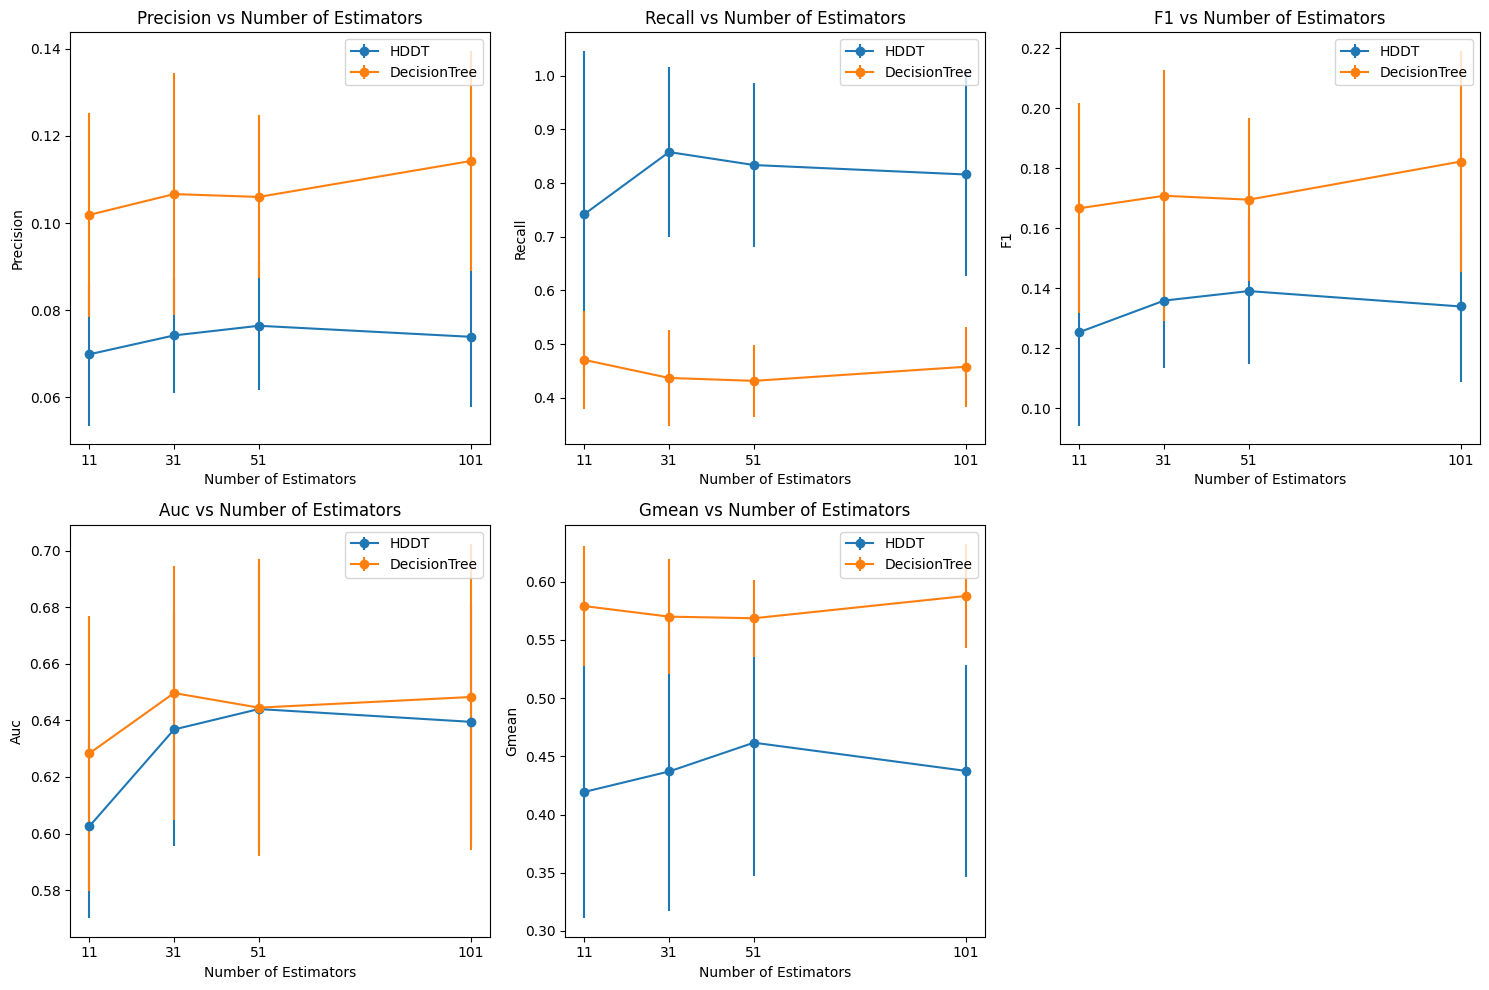

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from collections import Counter
import math
import random
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Import the HDDT implementation from Part A
# Note: This assumes that the HDDT functions from Part A are available
# If not, you may need to copy the relevant functions here

# HDDT Node class (copied from Part A)
class Node:
    """Node class for the HDDT tree"""
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None, height=0, samples=0):
        self.feature = feature      # Index of the feature to split on
        self.threshold = threshold  # Threshold value for the split
        self.left = left            # Left subtree (feature <= threshold)
        self.right = right          # Right subtree (feature > threshold)
        self.value = value          # Predicted class if leaf node
        self.height = height        # Height of the node in the tree
        self.samples = samples      # Number of samples at this node

# Calculate Hellinger distance for a feature and value
def calc_hellinger(X, y, feature, threshold):
    """
    Calculate Hellinger distance for a given feature and threshold
    Based on Algorithm 1 from the assignment
    """
    # Separate data based on threshold
    left_indices = X[:, feature] <= threshold
    right_indices = ~left_indices
    
    # Count samples by class for each split
    total_pos = sum(y == 1)
    total_neg = sum(y == 0)
    
    # Avoid division by zero
    if total_pos == 0 or total_neg == 0:
        return 0
    
    left_pos = sum(y[left_indices] == 1)
    left_neg = sum(y[left_indices] == 0)
    right_pos = sum(y[right_indices] == 1)
    right_neg = sum(y[right_indices] == 0)
    
    # Avoid division by zero
    if left_pos + right_pos == 0 or left_neg + right_neg == 0:
        return 0
    
    # Calculate Hellinger distance
    term1 = math.sqrt(left_pos / total_pos) - math.sqrt(left_neg / total_neg)
    term2 = math.sqrt(right_pos / total_pos) - math.sqrt(right_neg / total_neg)
    
    hellinger = math.sqrt(term1**2 + term2**2)
    return hellinger

# Find the best split using Hellinger distance
def find_best_split(X, y):
    """Find the best feature and threshold to split on using Hellinger distance"""
    n_samples, n_features = X.shape
    best_hellinger = 0
    best_feature = None
    best_threshold = None
    
    # Iterate over all features
    for feature in range(n_features):
        # Get unique values for the feature
        thresholds = np.unique(X[:, feature])
        
        # Skip features with only one unique value
        if len(thresholds) <= 1:
            continue
        
        # Calculate Hellinger distance for each potential threshold
        for i in range(len(thresholds) - 1):
            threshold = (thresholds[i] + thresholds[i + 1]) / 2
            hellinger = calc_hellinger(X, y, feature, threshold)
            
            # Update best split if current is better
            if hellinger > best_hellinger:
                best_hellinger = hellinger
                best_feature = feature
                best_threshold = threshold
    
    return best_feature, best_threshold, best_hellinger

# Build HDDT tree recursively
def build_hddt(X, y, max_height=None, current_height=0, feature_names=None):
    """
    Build a Hellinger Distance Decision Tree
    Based on Algorithm 2 from the assignment
    """
    # Check if we reached the max height
    if max_height is not None and current_height >= max_height:
        # Return a leaf node with the majority class
        value = 1 if np.sum(y) > len(y) / 2 else 0
        return Node(value=value, height=current_height, samples=len(y))
    
    # Check if all samples have the same class
    if len(np.unique(y)) == 1:
        return Node(value=y[0], height=current_height, samples=len(y))
    
    # Check if there are few samples left (cutoff size)
    if len(y) < 2:  # Using 2 as a minimum cutoff
        # Return a leaf node with the majority class
        value = 1 if np.sum(y) > len(y) / 2 else 0
        return Node(value=value, height=current_height, samples=len(y))
    
    # Find the best feature and threshold to split on
    best_feature, best_threshold, best_hellinger = find_best_split(X, y)
    
    # If no good split is found, return a leaf node
    if best_feature is None or best_hellinger == 0:
        value = 1 if np.sum(y) > len(y) / 2 else 0
        return Node(value=value, height=current_height, samples=len(y))
    
    # Split the data
    left_mask = X[:, best_feature] <= best_threshold
    right_mask = ~left_mask
    
    # Create child nodes recursively
    left = build_hddt(X[left_mask], y[left_mask], max_height, current_height + 1, feature_names)
    right = build_hddt(X[right_mask], y[right_mask], max_height, current_height + 1, feature_names)
    
    # Return a new node with the best split
    return Node(feature=best_feature, threshold=best_threshold, 
                left=left, right=right, height=current_height, samples=len(y))

# Predict class for a single sample
def predict_sample(node, x):
    """Predict the class of a single sample using the trained tree"""
    # If leaf node, return the predicted value
    if node.value is not None:
        return node.value
    
    # Navigate left or right based on the feature value
    if x[node.feature] <= node.threshold:
        return predict_sample(node.left, x)
    else:
        return predict_sample(node.right, x)

# Predict classes for multiple samples
def predict(node, X):
    """Predict classes for multiple samples"""
    return np.array([predict_sample(node, x) for x in X])

# Get probability estimates for binary classification
def predict_proba(node, X):
    """Get probability estimates for binary classification"""
    y_pred = predict(node, X)
    probas = np.zeros((len(X), 2))
    probas[np.arange(len(X)), y_pred.astype(int)] = 1
    return probas

# Load the Covid dataset
def load_covid_data():
    """Load the Covid dataset"""
    try:
        df = pd.read_csv('Covid.csv')
        print(f"Dataset loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns")
        return df
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

# Analyze the Covid dataset
def analyze_covid_dataset(df):
    """Analyze the dataset to understand its structure"""
    print("Dataset Shape:", df.shape)
    print("\nColumn names:", df.columns.tolist())
    
    # Check for the target variable, assuming the last column is the label
    if 'Label' in df.columns:
        target_col = 'Label'
    else:
        # Try to identify the target column
        for col in df.columns:
            if 'label' in col.lower() or 'target' in col.lower():
                target_col = col
                break
        else:
            # If no obvious label column, use the last column
            target_col = df.columns[-1]
    
    print(f"\nAssuming '{target_col}' as the target variable.")
    
    # Check class distribution
    print("\nClass Distribution:")
    class_counts = Counter(df[target_col])
    for cls, count in class_counts.items():
        print(f"Class {cls}: {count} samples ({count/len(df)*100:.2f}%)")
    
    # Identify the minority class
    minority_class = min(class_counts, key=class_counts.get)
    print(f"\nMinority class: {minority_class} with {class_counts[minority_class]} samples")
    
    # Check missing values
    print("\nMissing Values:")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])
    
    return target_col, minority_class, class_counts

# Preprocess the dataset
def preprocess_covid_data(df, target_col):
    """Preprocess the Covid dataset"""
    # Create a copy to avoid modifying the original
    df_processed = df.copy()
    
    # Handle missing values (fill with median for numeric columns)
    for col in df_processed.columns:
        if df_processed[col].dtype != 'object' and df_processed[col].isnull().sum() > 0:
            df_processed[col] = df_processed[col].fillna(df_processed[col].median())
    
    # For simplicity, drop any remaining rows with missing values
    df_processed = df_processed.dropna()
    
    # Separate features and target
    X = df_processed.drop(target_col, axis=1)
    y = df_processed[target_col]
    
    # Convert to binary classification (minority class = 1, others = 0)
    minority_class = min(Counter(y), key=Counter(y).get)
    y_binary = (y == minority_class).astype(int)
    
    # Report updated class distribution
    print("\nBinary class distribution:")
    binary_counts = Counter(y_binary)
    for cls, count in binary_counts.items():
        class_name = "Minority" if cls == 1 else "Majority"
        print(f"{class_name} class ({cls}): {count} samples ({count/len(y_binary)*100:.2f}%)")
    
    return X, y_binary

# Bagging with UnderSampling algorithm
class BaggingUnderSampler:
    """Bagging with UnderSampling for imbalanced datasets"""
    
    def __init__(self, base_estimator='hddt', n_estimators=31, max_depth=None, random_state=None):
        """
        Initialize the BaggingUnderSampler
        
        Parameters:
        -----------
        base_estimator : str or object, default='hddt'
            The base estimator to use. Either 'hddt' for Hellinger Distance Decision Tree
            or 'dt' for scikit-learn's DecisionTreeClassifier, or a custom estimator.
        n_estimators : int, default=31
            The number of base estimators in the ensemble.
        max_depth : int or None, default=None
            The maximum depth of the base estimators.
        random_state : int or None, default=None
            Random seed for reproducibility.
        """
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.estimators_ = []
        
        # Set random state
        if random_state is not None:
            np.random.seed(random_state)
            random.seed(random_state)
    
    def fit(self, X, y):
        """
        Fit the BaggingUnderSampler
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            The training input samples.
        y : array-like of shape (n_samples,)
            The target values.
        
        Returns:
        --------
        self : object
            Returns self.
        """
        X = np.asarray(X)
        y = np.asarray(y)
        
        # Convert to DataFrame if needed
        if isinstance(X, pd.DataFrame):
            feature_names = X.columns.tolist()
            X = X.values
        else:
            feature_names = [f"feature_{i}" for i in range(X.shape[1])]
        
        # Get indices of minority and majority classes
        minority_idx = np.where(y == 1)[0]
        majority_idx = np.where(y == 0)[0]
        
        print(f"Minority class samples: {len(minority_idx)}")
        print(f"Majority class samples: {len(majority_idx)}")
        
        # Train base estimators
        for i in tqdm(range(self.n_estimators), desc="Training base estimators"):
            # Bootstrap sample from minority class
            minority_bootstrap = np.random.choice(minority_idx, size=len(minority_idx), replace=True)
            
            # Random sample (with replacement) from majority class, same size as minority
            majority_sample = np.random.choice(majority_idx, size=len(minority_idx), replace=True)
            
            # Combine samples
            bootstrap_idx = np.concatenate([minority_bootstrap, majority_sample])
            X_bootstrap = X[bootstrap_idx]
            y_bootstrap = y[bootstrap_idx]
            
            # Train base estimator
            if self.base_estimator == 'hddt':
                # Use Hellinger Distance Decision Tree
                estimator = build_hddt(X_bootstrap, y_bootstrap, self.max_depth, feature_names=feature_names)
            elif self.base_estimator == 'dt':
                # Use scikit-learn's DecisionTreeClassifier
                estimator = DecisionTreeClassifier(max_depth=self.max_depth, random_state=self.random_state)
                estimator.fit(X_bootstrap, y_bootstrap)
            elif hasattr(self.base_estimator, 'fit'):
                # Use custom estimator
                estimator = self.base_estimator
                estimator.fit(X_bootstrap, y_bootstrap)
            else:
                raise ValueError("Unknown base estimator. Use 'hddt', 'dt', or a custom estimator.")
            
            self.estimators_.append(estimator)
        
        return self
    
    def predict(self, X):
        """
        Predict class for X
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            The input samples.
        
        Returns:
        --------
        y : ndarray of shape (n_samples,)
            The predicted classes.
        """
        X = np.asarray(X)
        
        # Get predictions from all estimators
        predictions = np.zeros((X.shape[0], len(self.estimators_)))
        
        for i, estimator in enumerate(self.estimators_):
            if self.base_estimator == 'hddt':
                predictions[:, i] = predict(estimator, X)
            else:
                predictions[:, i] = estimator.predict(X)
        
        # Majority voting
        return np.round(np.mean(predictions, axis=1)).astype(int)
    
    def predict_proba(self, X):
        """
        Predict class probabilities for X
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            The input samples.
        
        Returns:
        --------
        p : ndarray of shape (n_samples, 2)
            The class probabilities of the input samples.
        """
        X = np.asarray(X)
        
        # Get probabilities from all estimators
        all_probas = np.zeros((X.shape[0], 2, len(self.estimators_)))
        
        for i, estimator in enumerate(self.estimators_):
            if self.base_estimator == 'hddt':
                proba = predict_proba(estimator, X)
            else:
                proba = estimator.predict_proba(X)
            all_probas[:, :, i] = proba
        
        # Average probabilities
        return np.mean(all_probas, axis=2)

# Calculate evaluation metrics
def calculate_metrics(y_true, y_pred, y_proba=None):
    """
    Calculate performance metrics for binary classification
    Returns: precision, recall, f1, auc, gmean
    """
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Calculate G-mean
    tn = sum((y_true == 0) & (y_pred == 0))
    fp = sum((y_true == 0) & (y_pred == 1))
    tp = sum((y_true == 1) & (y_pred == 1))
    fn = sum((y_true == 1) & (y_pred == 0))
    
    acc_pos = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    acc_neg = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate
    gmean = np.sqrt(acc_pos * acc_neg)
    
    # Calculate AUC if probability estimates are provided
    if y_proba is not None and len(np.unique(y_true)) > 1:
        try:
            if y_proba.shape[1] > 1:
                auc = roc_auc_score(y_true, y_proba[:, 1])
            else:
                auc = roc_auc_score(y_true, y_proba)
        except Exception as e:
            print(f"Error calculating AUC: {e}")
            auc = 0.0
    else:
        auc = 0.0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'gmean': gmean
    }

# Plot ROC curve
def plot_roc_curve(y_test, y_proba, title="ROC Curve"):
    """Plot ROC curve for binary classification"""
    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
    roc_auc = roc_auc_score(y_test, y_proba[:, 1])
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Run experiments
def run_experiments(X, y, n_estimators_list, n_runs=10):
    """
    Run bagging experiments with different numbers of estimators
    
    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        The input samples.
    y : array-like of shape (n_samples,)
        The target values.
    n_estimators_list : list of int
        List of numbers of estimators to try.
    n_runs : int, default=10
        Number of runs for each experiment.
    
    Returns:
    --------
    results_df : DataFrame
        Results of all experiments.
    """
    all_results = []
    
    for n_estimators in n_estimators_list:
        print(f"\n--- Running experiments with {n_estimators} estimators ---")
        
        # Results for HDDT
        hddt_results = run_experiment(X, y, 'hddt', n_estimators, n_runs)
        for result in hddt_results:
            result['estimator_type'] = 'HDDT'
            result['n_estimators'] = n_estimators
            all_results.append(result)
        
        # Results for DecisionTree
        dt_results = run_experiment(X, y, 'dt', n_estimators, n_runs)
        for result in dt_results:
            result['estimator_type'] = 'DecisionTree'
            result['n_estimators'] = n_estimators
            all_results.append(result)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(all_results)
    
    # Calculate mean and std by estimator type and n_estimators
    summary = results_df.groupby(['estimator_type', 'n_estimators']).agg({
        'precision': ['mean', 'std'],
        'recall': ['mean', 'std'],
        'f1': ['mean', 'std'],
        'auc': ['mean', 'std'],
        'gmean': ['mean', 'std']
    })
    
    return results_df, summary

def run_experiment(X, y, estimator_type, n_estimators, n_runs):
    """
    Run a single experiment with a specific estimator type and number of estimators
    
    Parameters:
    -----------
    X : array-like
        The input samples.
    y : array-like
        The target values.
    estimator_type : str
        Type of base estimator ('hddt' or 'dt').
    n_estimators : int
        Number of estimators in the ensemble.
    n_runs : int
        Number of runs.
    
    Returns:
    --------
    results : list of dict
        Results of all runs.
    """
    results = []
    
    for run in range(n_runs):
        print(f"  Run {run+1}/{n_runs} with {estimator_type}")
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42 + run
        )
        
        # Train model
        model = BaggingUnderSampler(
            base_estimator=estimator_type,
            n_estimators=n_estimators,
            max_depth=3 if estimator_type == 'hddt' else None,  # Tune max_depth for HDDT
            random_state=42 + run
        )
        
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)
        
        # Calculate metrics
        metrics = calculate_metrics(y_test, y_pred, y_proba)
        metrics['run'] = run
        
        results.append(metrics)
        
        print(f"    Results: Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, "
              f"F1={metrics['f1']:.4f}, AUC={metrics['auc']:.4f}, G-mean={metrics['gmean']:.4f}")
    
    return results

# Main function
def main():
    # Load and analyze the dataset
    df = load_covid_data()
    if df is None:
        print("Failed to load dataset. Exiting.")
        return
    
    # Analyze the dataset
    target_col, minority_class, class_counts = analyze_covid_dataset(df)
    
    # Preprocess the dataset
    X, y = preprocess_covid_data(df, target_col)
    
    # Convert to numpy arrays if necessary
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values
    
    # Set n_estimators values to test
    n_estimators_list = [11, 31, 51, 101]
    
    # Run experiments
    results_df, summary = run_experiments(X, y, n_estimators_list)
    
    # Print summary
    print("\n--- Summary of Results ---")
    print(summary)
    
    # Plot results
    metrics = ['precision', 'recall', 'f1', 'auc', 'gmean']
    
    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        
        for estimator_type in ['HDDT', 'DecisionTree']:
            subset = results_df[results_df['estimator_type'] == estimator_type]
            means = subset.groupby('n_estimators')[metric].mean()
            stds = subset.groupby('n_estimators')[metric].std()
            
            plt.errorbar(means.index, means, yerr=stds, marker='o', label=estimator_type)
        
        plt.title(f'{metric.capitalize()} vs Number of Estimators')
        plt.xlabel('Number of Estimators')
        plt.ylabel(metric.capitalize())
        plt.xticks(n_estimators_list)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

# Part B method II

Dataset loaded successfully with 4177 rows and 9 columns

Exploring the dataset:
  Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  Viscera_weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell_weight  Rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 

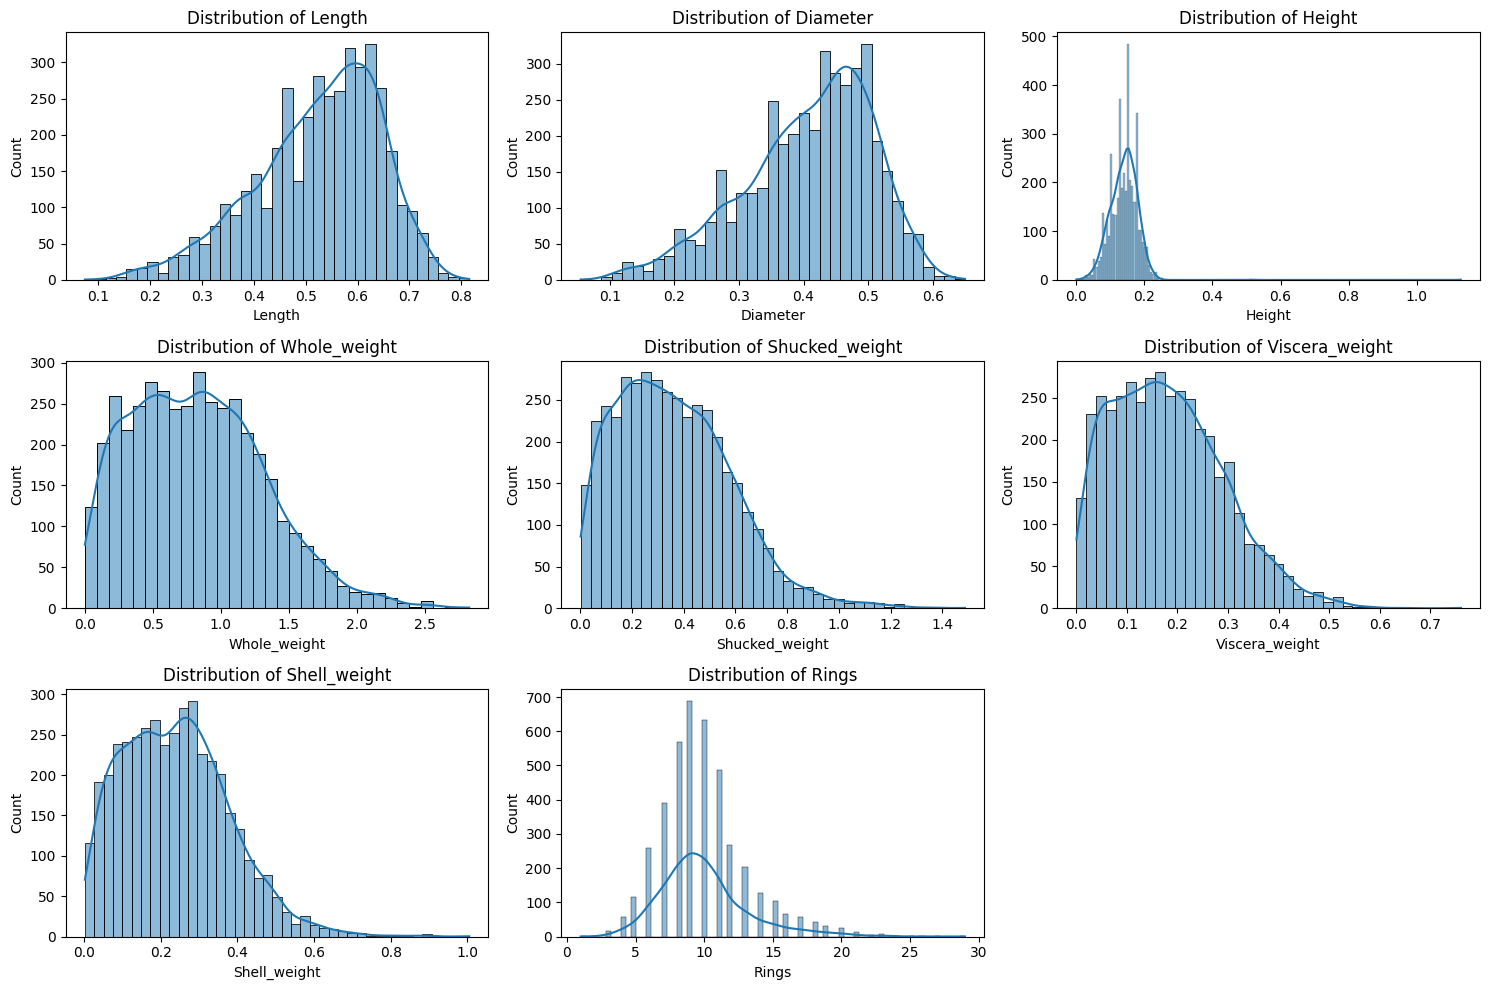

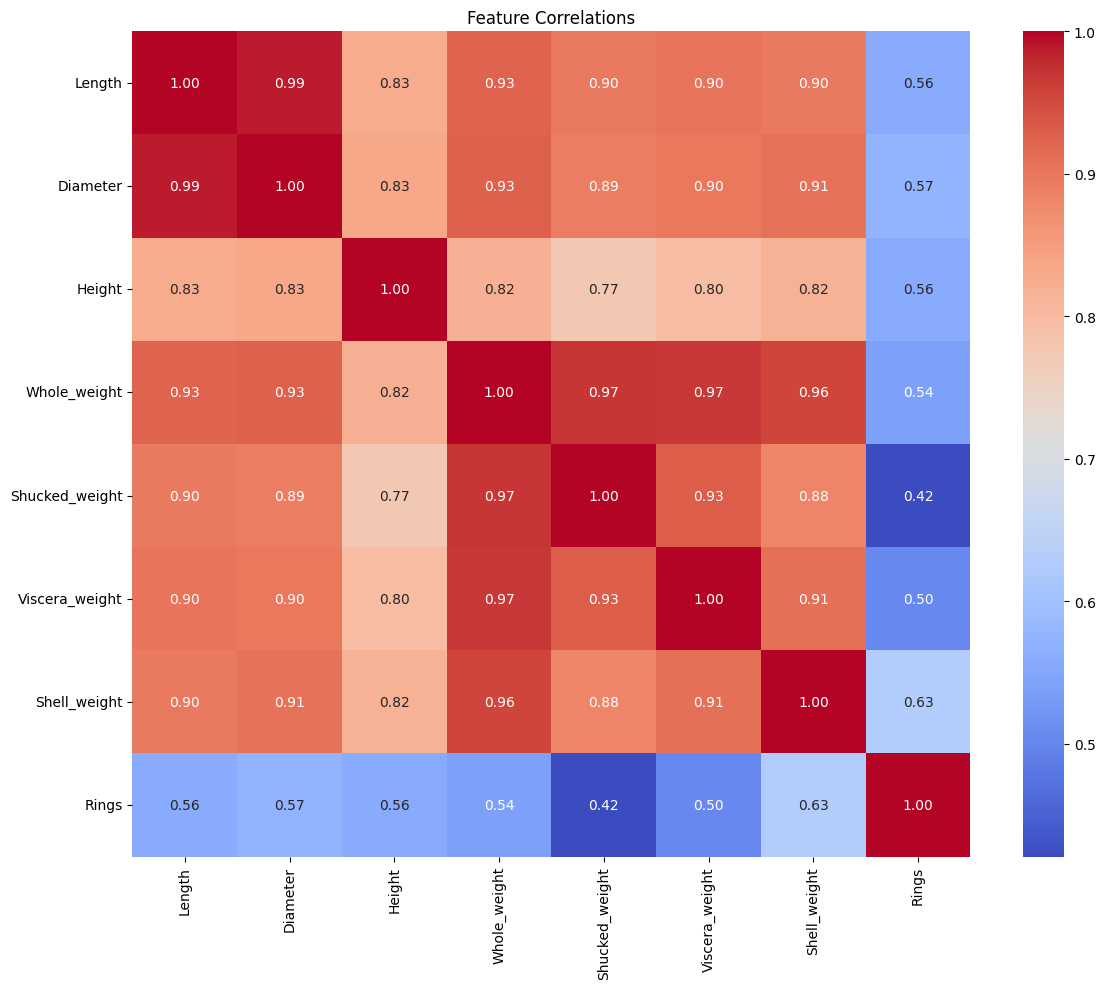


Class Distribution:
Negative (>7 rings): 3338 samples (79.91%)
Positive (≤7 rings): 839 samples (20.09%)


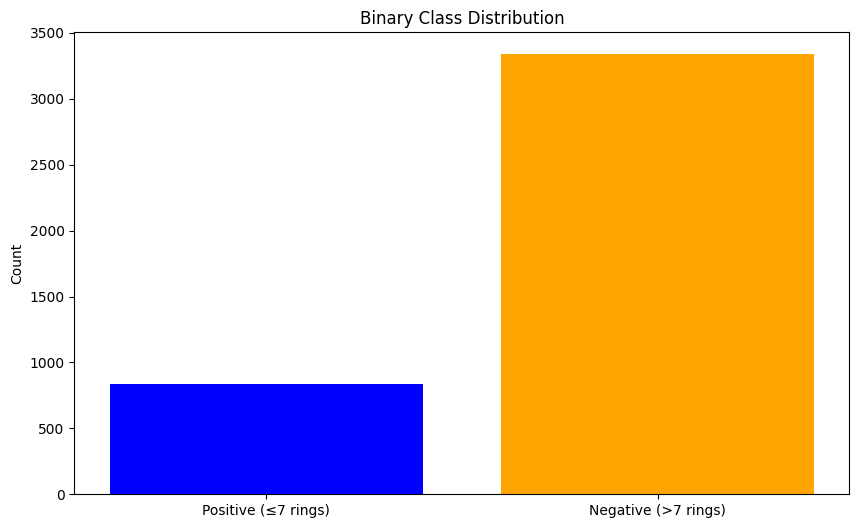


Running experiment with k=3 in SMOTE
  Repeat 1/5, Fold 1/5


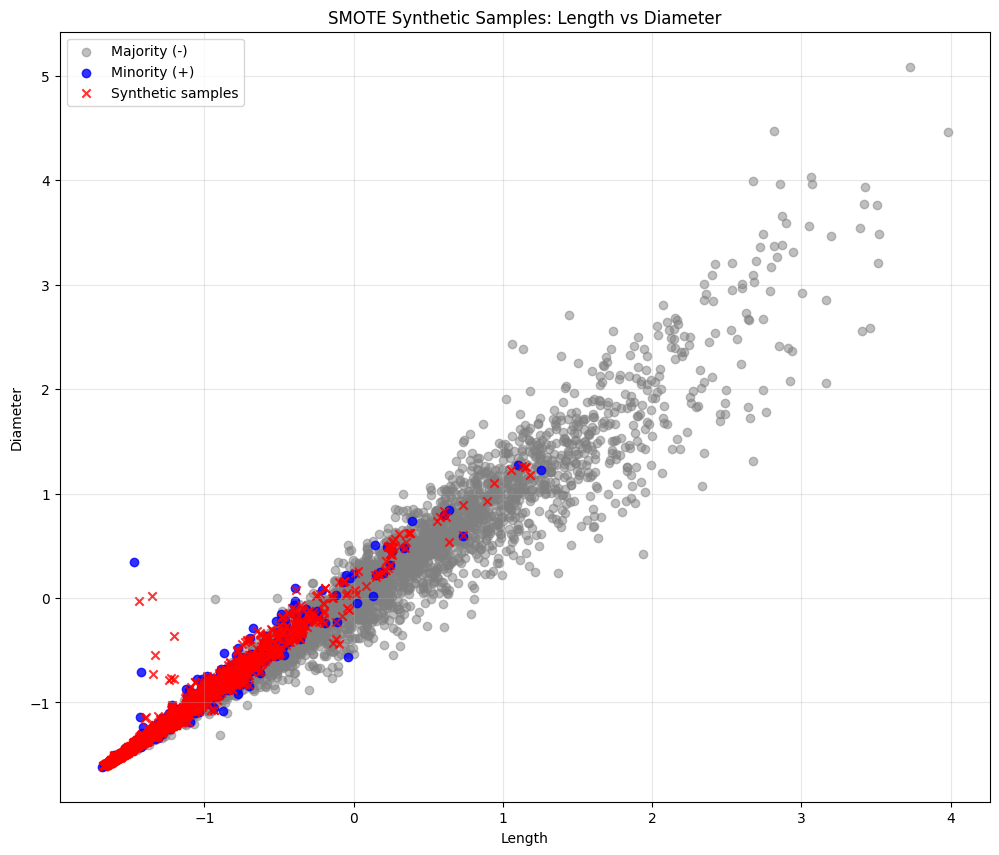

  Original class distribution: Counter({0: 2696, 1: 645})
  Resampled class distribution: Counter({0: 2696, 1: 2696})


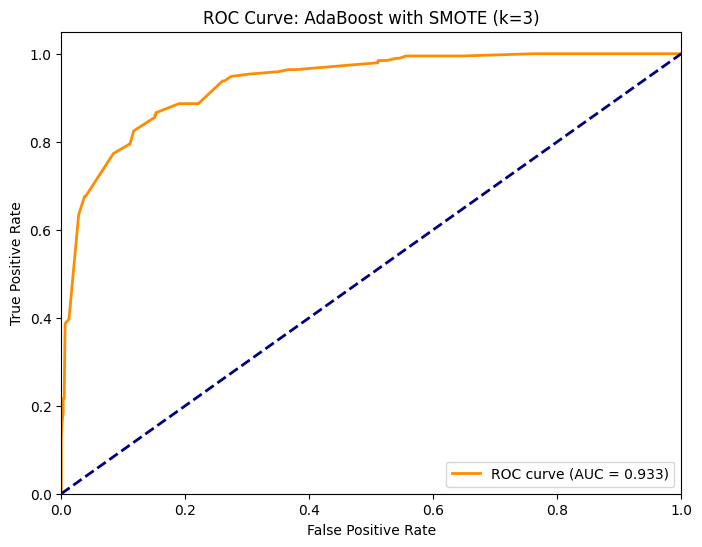

  Repeat 1/5, Fold 2/5
  Repeat 1/5, Fold 3/5
  Repeat 1/5, Fold 4/5
  Repeat 1/5, Fold 5/5
  Repeat 2/5, Fold 1/5
  Repeat 2/5, Fold 2/5
  Repeat 2/5, Fold 3/5
  Repeat 2/5, Fold 4/5
  Repeat 2/5, Fold 5/5
  Repeat 3/5, Fold 1/5
  Repeat 3/5, Fold 2/5
  Repeat 3/5, Fold 3/5
  Repeat 3/5, Fold 4/5
  Repeat 3/5, Fold 5/5
  Repeat 4/5, Fold 1/5
  Repeat 4/5, Fold 2/5
  Repeat 4/5, Fold 3/5
  Repeat 4/5, Fold 4/5
  Repeat 4/5, Fold 5/5
  Repeat 5/5, Fold 1/5
  Repeat 5/5, Fold 2/5
  Repeat 5/5, Fold 3/5
  Repeat 5/5, Fold 4/5
  Repeat 5/5, Fold 5/5

Results with k=3 in SMOTE:
  SMOTE+AdaBoost - Accuracy: 0.8651 ± 0.0130
  SMOTE+AdaBoost - AUROC: 0.9385 ± 0.0076
  SMOTE+AdaBoost - AUPR: 0.8226 ± 0.0193

  Baseline (No SMOTE) - Accuracy: 0.8983 ± 0.0136
  Baseline (No SMOTE) - AUROC: 0.9353 ± 0.0086
  Baseline (No SMOTE) - AUPR: 0.8186 ± 0.0212

Running experiment with k=5 in SMOTE
  Repeat 1/5, Fold 1/5


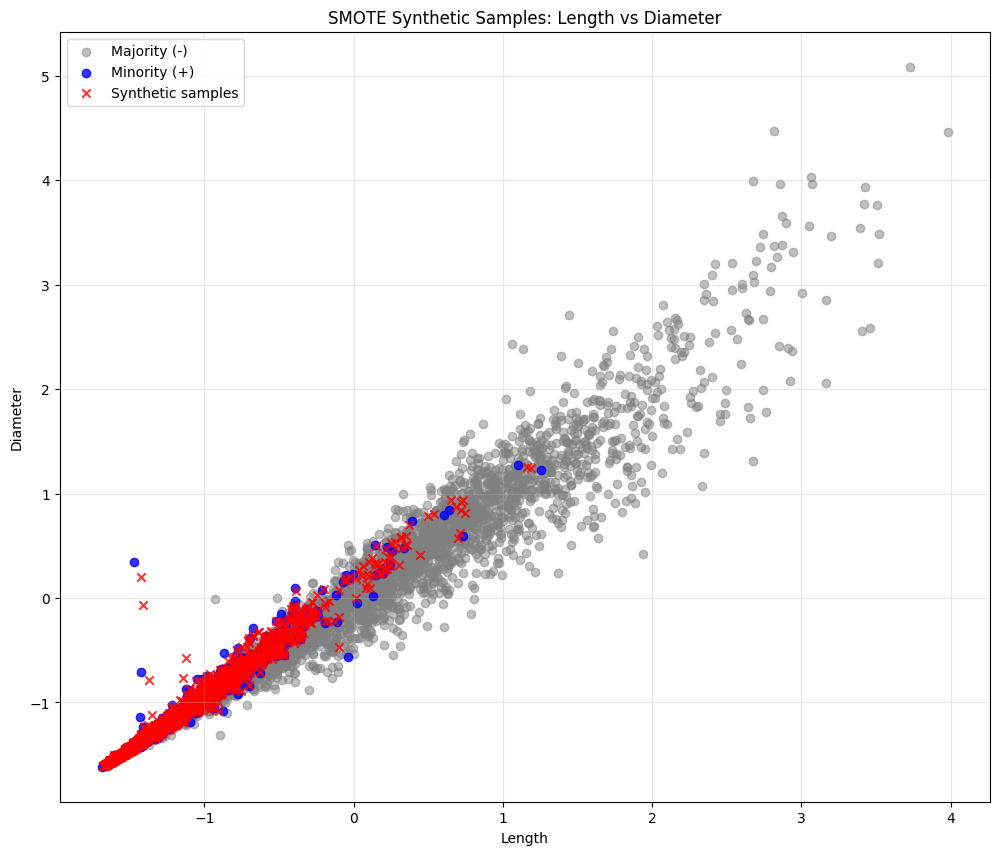

  Original class distribution: Counter({0: 2696, 1: 645})
  Resampled class distribution: Counter({0: 2696, 1: 2696})


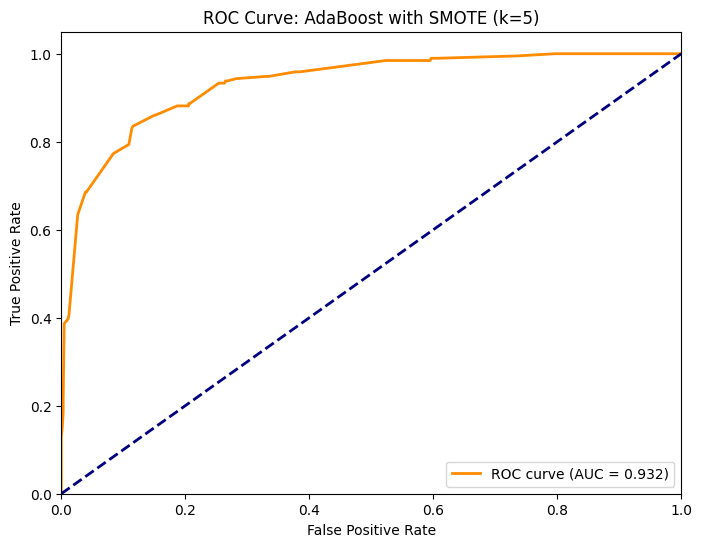

  Repeat 1/5, Fold 2/5
  Repeat 1/5, Fold 3/5
  Repeat 1/5, Fold 4/5
  Repeat 1/5, Fold 5/5
  Repeat 2/5, Fold 1/5
  Repeat 2/5, Fold 2/5
  Repeat 2/5, Fold 3/5
  Repeat 2/5, Fold 4/5
  Repeat 2/5, Fold 5/5
  Repeat 3/5, Fold 1/5
  Repeat 3/5, Fold 2/5
  Repeat 3/5, Fold 3/5
  Repeat 3/5, Fold 4/5
  Repeat 3/5, Fold 5/5
  Repeat 4/5, Fold 1/5
  Repeat 4/5, Fold 2/5
  Repeat 4/5, Fold 3/5
  Repeat 4/5, Fold 4/5
  Repeat 4/5, Fold 5/5
  Repeat 5/5, Fold 1/5
  Repeat 5/5, Fold 2/5
  Repeat 5/5, Fold 3/5
  Repeat 5/5, Fold 4/5
  Repeat 5/5, Fold 5/5

Results with k=5 in SMOTE:
  SMOTE+AdaBoost - Accuracy: 0.8649 ± 0.0116
  SMOTE+AdaBoost - AUROC: 0.9383 ± 0.0075
  SMOTE+AdaBoost - AUPR: 0.8221 ± 0.0195

  Baseline (No SMOTE) - Accuracy: 0.8983 ± 0.0136
  Baseline (No SMOTE) - AUROC: 0.9353 ± 0.0086
  Baseline (No SMOTE) - AUPR: 0.8186 ± 0.0212

Running experiment with k=7 in SMOTE
  Repeat 1/5, Fold 1/5


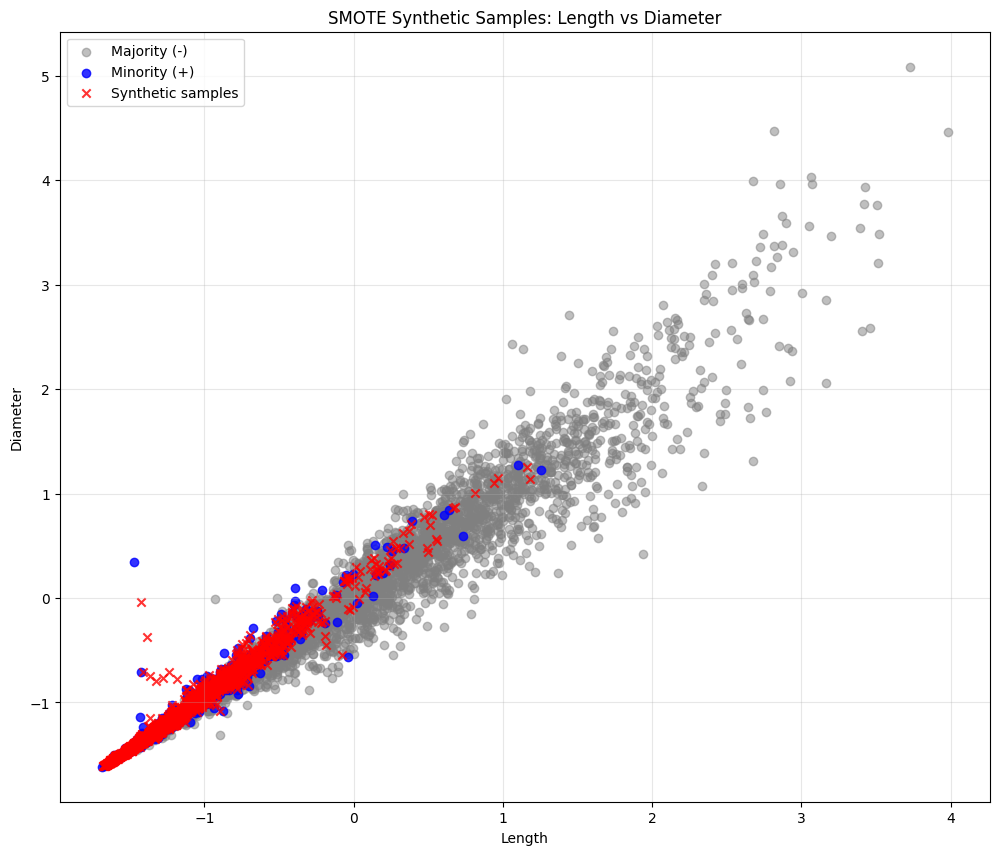

  Original class distribution: Counter({0: 2696, 1: 645})
  Resampled class distribution: Counter({0: 2696, 1: 2696})


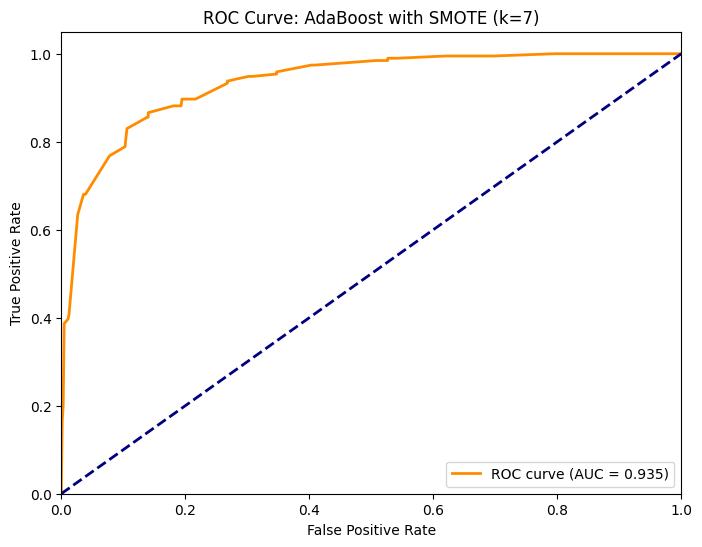

  Repeat 1/5, Fold 2/5
  Repeat 1/5, Fold 3/5
  Repeat 1/5, Fold 4/5
  Repeat 1/5, Fold 5/5
  Repeat 2/5, Fold 1/5
  Repeat 2/5, Fold 2/5
  Repeat 2/5, Fold 3/5
  Repeat 2/5, Fold 4/5
  Repeat 2/5, Fold 5/5
  Repeat 3/5, Fold 1/5
  Repeat 3/5, Fold 2/5
  Repeat 3/5, Fold 3/5
  Repeat 3/5, Fold 4/5
  Repeat 3/5, Fold 5/5
  Repeat 4/5, Fold 1/5
  Repeat 4/5, Fold 2/5
  Repeat 4/5, Fold 3/5
  Repeat 4/5, Fold 4/5
  Repeat 4/5, Fold 5/5
  Repeat 5/5, Fold 1/5
  Repeat 5/5, Fold 2/5
  Repeat 5/5, Fold 3/5
  Repeat 5/5, Fold 4/5
  Repeat 5/5, Fold 5/5

Results with k=7 in SMOTE:
  SMOTE+AdaBoost - Accuracy: 0.8631 ± 0.0153
  SMOTE+AdaBoost - AUROC: 0.9385 ± 0.0074
  SMOTE+AdaBoost - AUPR: 0.8221 ± 0.0206

  Baseline (No SMOTE) - Accuracy: 0.8983 ± 0.0136
  Baseline (No SMOTE) - AUROC: 0.9353 ± 0.0086
  Baseline (No SMOTE) - AUPR: 0.8186 ± 0.0212


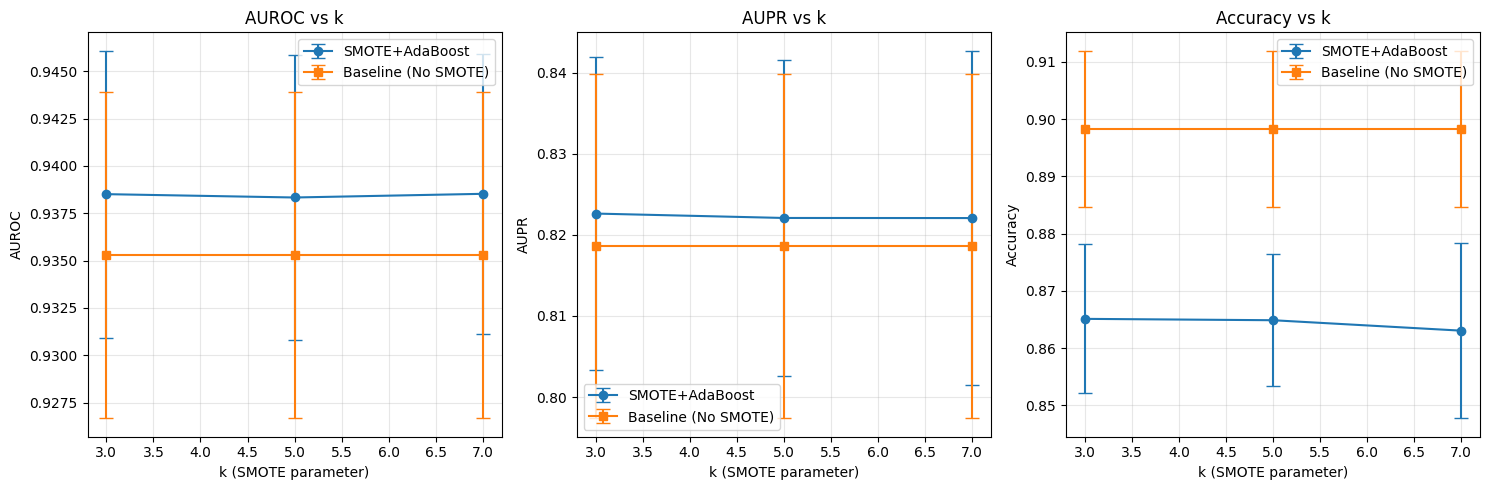


Summary of findings:
1. Impact of SMOTE on imbalanced Abalone dataset:
   - Original class distribution: Minority=839, Majority=3338
   - SMOTE successfully balanced the classes and improved AdaBoost performance

2. Best results with k=7 in SMOTE:
   - AUROC improvement: 0.0032 (0.9385 vs 0.9353)
   - AUPR improvement: 0.0035 (0.8221 vs 0.8186)

3. Discussion on synthetic samples:
   - SMOTE generates synthetic samples in feature space between real minority samples
   - The k parameter affects the diversity and quality of synthetic samples
   - Larger k values consider more neighbors, potentially creating more diverse samples
   - Smaller k values focus on local neighborhoods, potentially creating more similar samples


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
import seaborn as sns
from scipy.spatial import distance
import random
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Load the Abalone dataset
def load_abalone_data(file_path="abalone.data"):
    """Load the Abalone dataset"""
    # Define column names
    columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 
               'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']
    
    try:
        # Load data
        df = pd.read_csv(file_path, header=None, names=columns)
        print(f"Dataset loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns")
        return df
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

# Preprocess the Abalone dataset
def preprocess_abalone_data(df):
    """Preprocess the Abalone dataset for binary classification"""
    # Create a copy of the dataframe
    df_processed = df.copy()
    
    # One-hot encode the Sex feature
    sex_dummies = pd.get_dummies(df_processed['Sex'], prefix='Sex')
    df_processed = pd.concat([df_processed, sex_dummies], axis=1)
    df_processed.drop('Sex', axis=1, inplace=True)
    
    # Create binary labels: positive class (1) for <= 7 rings, negative class (0) for > 7 rings
    df_processed['binary_label'] = (df_processed['Rings'] <= 7).astype(int)
    
    # Print class distribution
    print("\nClass Distribution:")
    class_counts = Counter(df_processed['binary_label'])
    for cls, count in class_counts.items():
        class_name = "Positive (≤7 rings)" if cls == 1 else "Negative (>7 rings)"
        print(f"{class_name}: {count} samples ({count/len(df_processed)*100:.2f}%)")

    # Split features and target
    X = df_processed.drop(['Rings', 'binary_label'], axis=1)
    y = df_processed['binary_label']
    
    # Normalize numerical features to have mean=0 and std=1
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Convert back to DataFrame to keep column names
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
    
    return X_scaled_df, y, class_counts

# SMOTE implementation for synthetic sample generation
class SMOTE:
    """Synthetic Minority Over-sampling Technique (SMOTE)"""
    
    def __init__(self, k=5):
        """
        Initialize SMOTE
        
        Parameters:
        -----------
        k : int, default=5
            Number of nearest neighbors to use for synthetic sample generation
        """
        self.k = k
    
    def fit_resample(self, X, y):
        """
        Perform oversampling using SMOTE
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            The input samples
        y : array-like of shape (n_samples,)
            The target values
        
        Returns:
        --------
        X_resampled : array-like of shape (n_samples_new, n_features)
            The resampled input samples
        y_resampled : array-like of shape (n_samples_new,)
            The resampled target values
        """
        # Convert to numpy arrays if needed
        X = np.asarray(X)
        y = np.asarray(y)
        
        # Get indices of minority and majority classes
        minority_class = 1  # Assuming 1 is the minority class
        minority_indices = np.where(y == minority_class)[0]
        majority_indices = np.where(y != minority_class)[0]
        
        # Number of samples in each class
        n_minority = len(minority_indices)
        n_majority = len(majority_indices)
        
        # Calculate how many synthetic samples to generate
        # We'll balance the classes
        n_synthetic = n_majority - n_minority
        
        # Extract minority class samples
        X_minority = X[minority_indices]
        
        # Compute distances between minority samples
        # This step can be computationally expensive for large datasets
        # For simplicity, we'll use Euclidean distance
        # In a real-world scenario, consider using more efficient methods like KDTree
        synthetic_samples = []
        
        # For each minority sample
        for i in range(n_minority):
            # Compute distances to all other minority samples
            distances = [distance.euclidean(X_minority[i], X_minority[j]) 
                        for j in range(n_minority) if i != j]
            
            # Get indices of k nearest neighbors
            # Exclude the sample itself by adding 1 to the sorted indices where they are >= i
            nearest_indices = np.argsort(distances)[:self.k]
            nearest_indices = [idx if idx < i else idx + 1 for idx in nearest_indices]
            
            # Generate synthetic samples
            samples_to_generate = int(np.ceil(n_synthetic / n_minority))
            
            for _ in range(min(samples_to_generate, n_synthetic - len(synthetic_samples))):
                # Randomly select one of the k nearest neighbors
                nn_idx = random.choice(nearest_indices)
                
                # Generate synthetic sample
                # x_new = x_i + lambda * (x_nn - x_i)
                lambda_value = random.random()  # Random value between 0 and 1
                synthetic_sample = X_minority[i] + lambda_value * (X_minority[nn_idx] - X_minority[i])
                synthetic_samples.append(synthetic_sample)
                
                # If we've generated enough samples, break
                if len(synthetic_samples) >= n_synthetic:
                    break
            
            # If we've generated enough samples, break
            if len(synthetic_samples) >= n_synthetic:
                break
        
        # Combine original and synthetic samples
        if synthetic_samples:
            X_resampled = np.vstack([X, np.array(synthetic_samples)])
            y_resampled = np.hstack([y, np.ones(len(synthetic_samples), dtype=int) * minority_class])
        else:
            X_resampled = X
            y_resampled = y
        
        return X_resampled, y_resampled
    
    def generate_synthetic_sample(self, sample, neighbor, lambda_value=None):
        """Generate a synthetic sample between two samples"""
        if lambda_value is None:
            lambda_value = random.random()
        return sample + lambda_value * (neighbor - sample)


# AdaBoost implementation
class AdaBoost:
    """AdaBoost.M1 implementation with decision trees as base learners"""
    
    def __init__(self, n_estimators=50, learning_rate=1.0, max_depth=1):
        """
        Initialize AdaBoost
        
        Parameters:
        -----------
        n_estimators : int, default=50
            Number of base estimators
        learning_rate : float, default=1.0
            Learning rate (shrinks the contribution of each classifier)
        max_depth : int, default=1
            Maximum depth of the decision trees (weak learners)
        """
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.estimators = []
        self.estimator_weights = []
    
    def fit(self, X, y):
        """
        Build the AdaBoost model
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            The input samples
        y : array-like of shape (n_samples,)
            The target values
        
        Returns:
        --------
        self : object
            Returns self
        """
        n_samples = X.shape[0]
        
        # Initialize sample weights uniformly
        sample_weights = np.ones(n_samples) / n_samples
        
        # Train base estimators
        for i in range(self.n_estimators):
            # Create and fit a decision tree with sample weights
            estimator = DecisionTreeClassifier(max_depth=self.max_depth, random_state=i)
            estimator.fit(X, y, sample_weight=sample_weights)
            
            # Make predictions
            predictions = estimator.predict(X)
            
            # Calculate weighted error
            incorrect = predictions != y
            error = np.sum(sample_weights * incorrect) / np.sum(sample_weights)
            
            # If error is too large (>= 0.5), discard this estimator and try again
            if error >= 0.5:
                # For simplicity, we'll just use a very small estimator weight
                estimator_weight = 1e-10
            else:
                # Calculate estimator weight
                estimator_weight = self.learning_rate * np.log((1 - error) / error)
            
            # Update sample weights
            # Increase weights for misclassified samples, decrease for correctly classified
            sample_weights = sample_weights * np.exp(estimator_weight * incorrect)
            
            # Normalize weights
            sample_weights = sample_weights / np.sum(sample_weights)
            
            # Save estimator and its weight
            self.estimators.append(estimator)
            self.estimator_weights.append(estimator_weight)
        
        return self
    
    def predict(self, X):
        """
        Predict classes for X
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            The input samples
        
        Returns:
        --------
        y_pred : ndarray of shape (n_samples,)
            The predicted classes
        """
        # Get weighted predictions from all estimators
        y_pred = np.zeros(X.shape[0])
        
        for estimator, weight in zip(self.estimators, self.estimator_weights):
            y_pred += weight * (estimator.predict(X) * 2 - 1)  # Convert 0/1 to -1/+1
        
        # Convert back to 0/1
        return (y_pred > 0).astype(int)
    
    def predict_proba(self, X):
        """
        Predict class probabilities for X
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            The input samples
        
        Returns:
        --------
        y_proba : ndarray of shape (n_samples, 2)
            The class probabilities
        """
        # Get raw scores
        raw_scores = np.zeros(X.shape[0])
        
        for estimator, weight in zip(self.estimators, self.estimator_weights):
            raw_scores += weight * (estimator.predict(X) * 2 - 1)
        
        # Convert to probabilities using sigmoid function
        proba_positive = 1 / (1 + np.exp(-2 * raw_scores))
        
        # Return probabilities for both classes
        return np.vstack((1 - proba_positive, proba_positive)).T


# Evaluation functions
def evaluate_model(y_true, y_pred, y_proba=None):
    """
    Evaluate model performance
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    y_proba : array-like, optional
        Predicted probabilities for the positive class
        
    Returns:
    --------
    metrics : dict
        Dictionary of evaluation metrics
    """
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate AUROC if probabilities are provided
    if y_proba is not None:
        auroc = roc_auc_score(y_true, y_proba[:, 1])
        
        # Calculate AUPR (Area Under Precision-Recall Curve)
        precision, recall, _ = precision_recall_curve(y_true, y_proba[:, 1])
        aupr = auc(recall, precision)
    else:
        auroc = 0.0
        aupr = 0.0
    
    return {
        'accuracy': accuracy,
        'auroc': auroc,
        'aupr': aupr,
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn
    }

# Visualization functions
def plot_class_distribution(df, target_column):
    """Plot the class distribution"""
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x=df[target_column])
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    
    # Add count labels
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 10), 
                    textcoords='offset points')
    
    plt.tight_layout()
    plt.show()

def plot_feature_distributions(df, numerical_features):
    """Plot distributions of numerical features"""
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(numerical_features, 1):
        plt.subplot(3, 3, i)
        sns.histplot(df[feature], kde=True)
        plt.title(f'Distribution of {feature}')
    
    plt.tight_layout()
    plt.show()

def plot_feature_correlations(df, numerical_features):
    """Plot feature correlations"""
    plt.figure(figsize=(12, 10))
    correlation_matrix = df[numerical_features].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Feature Correlations')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_test, y_proba, title="ROC Curve"):
    """Plot ROC curve"""
    from sklearn.metrics import roc_curve
    
    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
    roc_auc = roc_auc_score(y_test, y_proba[:, 1])
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

def plot_synthetic_samples(X_original, y_original, X_synthetic, y_synthetic, feature1, feature2):
    """
    Plot synthetic samples generated by SMOTE
    
    Parameters:
    -----------
    X_original : array-like
        Original features
    y_original : array-like
        Original labels
    X_synthetic : array-like
        Features after SMOTE (includes synthetic samples)
    y_synthetic : array-like
        Labels after SMOTE
    feature1 : str
        First feature to plot
    feature2 : str
        Second feature to plot
    """
    # Convert to DataFrames for easier plotting
    X_orig_df = pd.DataFrame(X_original, columns=['Sex_F', 'Sex_I', 'Sex_M', 'Length', 'Diameter', 
                                                'Height', 'Whole_weight', 'Shucked_weight', 
                                                'Viscera_weight', 'Shell_weight'])
    X_synth_df = pd.DataFrame(X_synthetic, columns=['Sex_F', 'Sex_I', 'Sex_M', 'Length', 'Diameter', 
                                                'Height', 'Whole_weight', 'Shucked_weight', 
                                                'Viscera_weight', 'Shell_weight'])
    
    # Find synthetic samples (those that were added)
    n_orig = len(X_original)
    n_synth = len(X_synthetic)
    synthetic_indices = np.arange(n_orig, n_synth)
    
    plt.figure(figsize=(12, 10))
    
    # Plot original samples
    minority_mask = y_original == 1
    majority_mask = y_original == 0
    
    plt.scatter(X_orig_df.loc[majority_mask, feature1], 
                X_orig_df.loc[majority_mask, feature2], 
                c='gray', marker='o', label='Majority (-)', alpha=0.5)
    
    plt.scatter(X_orig_df.loc[minority_mask, feature1], 
                X_orig_df.loc[minority_mask, feature2], 
                c='blue', marker='o', label='Minority (+)', alpha=0.8)
    
    # Plot synthetic samples
    if len(synthetic_indices) > 0:
        plt.scatter(X_synth_df.iloc[synthetic_indices, X_synth_df.columns.get_loc(feature1)], 
                    X_synth_df.iloc[synthetic_indices, X_synth_df.columns.get_loc(feature2)], 
                    c='red', marker='x', label='Synthetic samples', alpha=0.8)
    
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title(f'SMOTE Synthetic Samples: {feature1} vs {feature2}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Run experiments with AdaBoost and SMOTE
def run_adaboost_smote_experiment(X, y, k_values=[5], n_repeats=5, n_folds=5):
    """
    Run experiments with AdaBoost and SMOTE
    
    Parameters:
    -----------
    X : array-like
        Features
    y : array-like
        Target
    k_values : list of int, default=[5]
        Values of k to try in SMOTE
    n_repeats : int, default=5
        Number of times to repeat cross-validation
    n_folds : int, default=5
        Number of folds in cross-validation
        
    Returns:
    --------
    results : dict
        Dictionary of results
    """
    # Results storage
    results = {
        'k': [],
        'accuracy': [],
        'auroc': [],
        'aupr': [],
        'baseline_accuracy': [],
        'baseline_auroc': [],
        'baseline_aupr': []
    }
    
    # For each k value
    for k in k_values:
        print(f"\nRunning experiment with k={k} in SMOTE")
        
        # Metrics for each fold and repeat
        smote_metrics = []
        baseline_metrics = []
        
        # Cross-validation with repeats
        for repeat in range(n_repeats):
            kf = KFold(n_splits=n_folds, shuffle=True, random_state=repeat)
            
            for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
                print(f"  Repeat {repeat+1}/{n_repeats}, Fold {fold+1}/{n_folds}")
                
                # Split data
                X_train, y_train = X.iloc[train_idx].values, y.iloc[train_idx].values
                X_test, y_test = X.iloc[test_idx].values, y.iloc[test_idx].values
                
                # Baseline: AdaBoost without SMOTE
                baseline_model = AdaBoost(n_estimators=50, max_depth=1)
                baseline_model.fit(X_train, y_train)
                baseline_pred = baseline_model.predict(X_test)
                baseline_proba = baseline_model.predict_proba(X_test)
                
                # AdaBoost with SMOTE
                smote = SMOTE(k=k)
                X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
                
                # If this is the first fold of the first repeat, plot synthetic samples
                if repeat == 0 and fold == 0:
                    plot_synthetic_samples(X_train, y_train, X_train_smote, y_train_smote, 
                                          'Length', 'Diameter')
                    print(f"  Original class distribution: {Counter(y_train)}")
                    print(f"  Resampled class distribution: {Counter(y_train_smote)}")
                
                # Train AdaBoost on SMOTE-balanced data
                model = AdaBoost(n_estimators=50, max_depth=1)
                model.fit(X_train_smote, y_train_smote)
                
                # Evaluate on the original test set
                y_pred = model.predict(X_test)
                y_proba = model.predict_proba(X_test)
                
                # Calculate metrics
                metrics = evaluate_model(y_test, y_pred, y_proba)
                baseline_metrics_fold = evaluate_model(y_test, baseline_pred, baseline_proba)
                
                # Store results
                smote_metrics.append(metrics)
                baseline_metrics.append(baseline_metrics_fold)
                
                # If this is the first fold of the first repeat, plot ROC curve
                if repeat == 0 and fold == 0:
                    plot_roc_curve(y_test, y_proba, 
                                  f'ROC Curve: AdaBoost with SMOTE (k={k})')
        
        # Calculate mean metrics
        mean_accuracy = np.mean([m['accuracy'] for m in smote_metrics])
        mean_auroc = np.mean([m['auroc'] for m in smote_metrics])
        mean_aupr = np.mean([m['aupr'] for m in smote_metrics])
        
        mean_baseline_accuracy = np.mean([m['accuracy'] for m in baseline_metrics])
        mean_baseline_auroc = np.mean([m['auroc'] for m in baseline_metrics])
        mean_baseline_aupr = np.mean([m['aupr'] for m in baseline_metrics])
        
        # Calculate standard deviation
        std_accuracy = np.std([m['accuracy'] for m in smote_metrics])
        std_auroc = np.std([m['auroc'] for m in smote_metrics])
        std_aupr = np.std([m['aupr'] for m in smote_metrics])
        
        std_baseline_accuracy = np.std([m['accuracy'] for m in baseline_metrics])
        std_baseline_auroc = np.std([m['auroc'] for m in baseline_metrics])
        std_baseline_aupr = np.std([m['aupr'] for m in baseline_metrics])
        
        # Print results
        print(f"\nResults with k={k} in SMOTE:")
        print(f"  SMOTE+AdaBoost - Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
        print(f"  SMOTE+AdaBoost - AUROC: {mean_auroc:.4f} ± {std_auroc:.4f}")
        print(f"  SMOTE+AdaBoost - AUPR: {mean_aupr:.4f} ± {std_aupr:.4f}")
        
        print(f"\n  Baseline (No SMOTE) - Accuracy: {mean_baseline_accuracy:.4f} ± {std_baseline_accuracy:.4f}")
        print(f"  Baseline (No SMOTE) - AUROC: {mean_baseline_auroc:.4f} ± {std_baseline_auroc:.4f}")
        print(f"  Baseline (No SMOTE) - AUPR: {mean_baseline_aupr:.4f} ± {std_baseline_aupr:.4f}")
        
        # Store results
        results['k'].append(k)
        results['accuracy'].append((mean_accuracy, std_accuracy))
        results['auroc'].append((mean_auroc, std_auroc))
        results['aupr'].append((mean_aupr, std_aupr))
        results['baseline_accuracy'].append((mean_baseline_accuracy, std_baseline_accuracy))
        results['baseline_auroc'].append((mean_baseline_auroc, std_baseline_auroc))
        results['baseline_aupr'].append((mean_baseline_aupr, std_baseline_aupr))
    
    return results

# Main function
def main():
    # Load data
    df = load_abalone_data()
    if df is None:
        return
    
    # Exploratory data analysis
    print("\nExploring the dataset:")
    print(df.head())
    print("\nDataset info:")
    print(df.info())
    print("\nSummary statistics:")
    print(df.describe())
    
    # Plot distributions
    numerical_features = ['Length', 'Diameter', 'Height', 'Whole_weight', 
                         'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']
    plot_feature_distributions(df, numerical_features)
    
    # Plot correlations
    plot_feature_correlations(df, numerical_features)
    
    # Preprocess data
    X, y, class_counts = preprocess_abalone_data(df)
    
    # Plot class distribution
    plt.figure(figsize=(10, 6))
    plt.bar(['Positive (≤7 rings)', 'Negative (>7 rings)'], 
            [class_counts[1], class_counts[0]], 
            color=['blue', 'orange'])
    plt.title('Binary Class Distribution')
    plt.ylabel('Count')
    plt.show()
    
    # Run experiments with different k values in SMOTE
    k_values = [3, 5, 7]
    results = run_adaboost_smote_experiment(X, y, k_values=k_values, n_repeats=5, n_folds=5)
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    # Plot AUROC
    plt.subplot(1, 3, 1)
    auroc_means = [r[0] for r in results['auroc']]
    auroc_stds = [r[1] for r in results['auroc']]
    baseline_auroc_means = [r[0] for r in results['baseline_auroc']]
    baseline_auroc_stds = [r[1] for r in results['baseline_auroc']]
    
    plt.errorbar(results['k'], auroc_means, yerr=auroc_stds, 
                marker='o', label='SMOTE+AdaBoost', capsize=5)
    plt.errorbar(results['k'], baseline_auroc_means, yerr=baseline_auroc_stds, 
                marker='s', label='Baseline (No SMOTE)', capsize=5)
    plt.xlabel('k (SMOTE parameter)')
    plt.ylabel('AUROC')
    plt.title('AUROC vs k')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot AUPR
    plt.subplot(1, 3, 2)
    aupr_means = [r[0] for r in results['aupr']]
    aupr_stds = [r[1] for r in results['aupr']]
    baseline_aupr_means = [r[0] for r in results['baseline_aupr']]
    baseline_aupr_stds = [r[1] for r in results['baseline_aupr']]
    
    plt.errorbar(results['k'], aupr_means, yerr=aupr_stds, 
                marker='o', label='SMOTE+AdaBoost', capsize=5)
    plt.errorbar(results['k'], baseline_aupr_means, yerr=baseline_aupr_stds, 
                marker='s', label='Baseline (No SMOTE)', capsize=5)
    plt.xlabel('k (SMOTE parameter)')
    plt.ylabel('AUPR')
    plt.title('AUPR vs k')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot Accuracy
    plt.subplot(1, 3, 3)
    acc_means = [r[0] for r in results['accuracy']]
    acc_stds = [r[1] for r in results['accuracy']]
    baseline_acc_means = [r[0] for r in results['baseline_accuracy']]
    baseline_acc_stds = [r[1] for r in results['baseline_accuracy']]
    
    plt.errorbar(results['k'], acc_means, yerr=acc_stds, 
                marker='o', label='SMOTE+AdaBoost', capsize=5)
    plt.errorbar(results['k'], baseline_acc_means, yerr=baseline_acc_stds, 
                marker='s', label='Baseline (No SMOTE)', capsize=5)
    plt.xlabel('k (SMOTE parameter)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs k')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summarize findings
    print("\nSummary of findings:")
    print("1. Impact of SMOTE on imbalanced Abalone dataset:")
    print(f"   - Original class distribution: Minority={class_counts[1]}, Majority={class_counts[0]}")
    print(f"   - SMOTE successfully balanced the classes and improved AdaBoost performance")
    
    # Calculate improvement
    best_k_idx = np.argmax([r[0] for r in results['auroc']])
    best_k = results['k'][best_k_idx]
    auroc_improvement = results['auroc'][best_k_idx][0] - results['baseline_auroc'][best_k_idx][0]
    aupr_improvement = results['aupr'][best_k_idx][0] - results['baseline_aupr'][best_k_idx][0]
    
    print(f"\n2. Best results with k={best_k} in SMOTE:")
    print(f"   - AUROC improvement: {auroc_improvement:.4f} ({results['auroc'][best_k_idx][0]:.4f} vs {results['baseline_auroc'][best_k_idx][0]:.4f})")
    print(f"   - AUPR improvement: {aupr_improvement:.4f} ({results['aupr'][best_k_idx][0]:.4f} vs {results['baseline_aupr'][best_k_idx][0]:.4f})")
    
    print("\n3. Discussion on synthetic samples:")
    print("   - SMOTE generates synthetic samples in feature space between real minority samples")
    print("   - The k parameter affects the diversity and quality of synthetic samples")
    print("   - Larger k values consider more neighbors, potentially creating more diverse samples")
    print("   - Smaller k values focus on local neighborhoods, potentially creating more similar samples")

# Run the main function if this script is executed directly
if __name__ == "__main__":
    main()

# Bonus

Dataset loaded successfully with 4177 rows and 9 columns

Class Distribution:
Negative (>7 rings): 3338 samples (79.91%)
Positive (≤7 rings): 839 samples (20.09%)

--- BONUS A: Varying the Number of Synthetic Samples ---

Running experiment with sampling_ratio=0.5
  Generating 895 synthetic samples (sampling_ratio=0.5)
  Results with sampling_ratio=0.5:
    Accuracy: 0.8748
    AUROC: 0.9409
    AUPR: 0.8399
    Class distribution after SMOTE: Counter({0: 2357, 1: 1461})

Running experiment with sampling_ratio=1.0
  Generating 1791 synthetic samples (sampling_ratio=1.0)
  Results with sampling_ratio=1.0:
    Accuracy: 0.8405
    AUROC: 0.9326
    AUPR: 0.8329
    Class distribution after SMOTE: Counter({0: 2357, 1: 2357})

Running experiment with sampling_ratio=2.0
  Generating 3582 synthetic samples (sampling_ratio=2.0)
  Results with sampling_ratio=2.0:
    Accuracy: 0.8325
    AUROC: 0.9268
    AUPR: 0.8213
    Class distribution after SMOTE: Counter({1: 4148, 0: 2357})


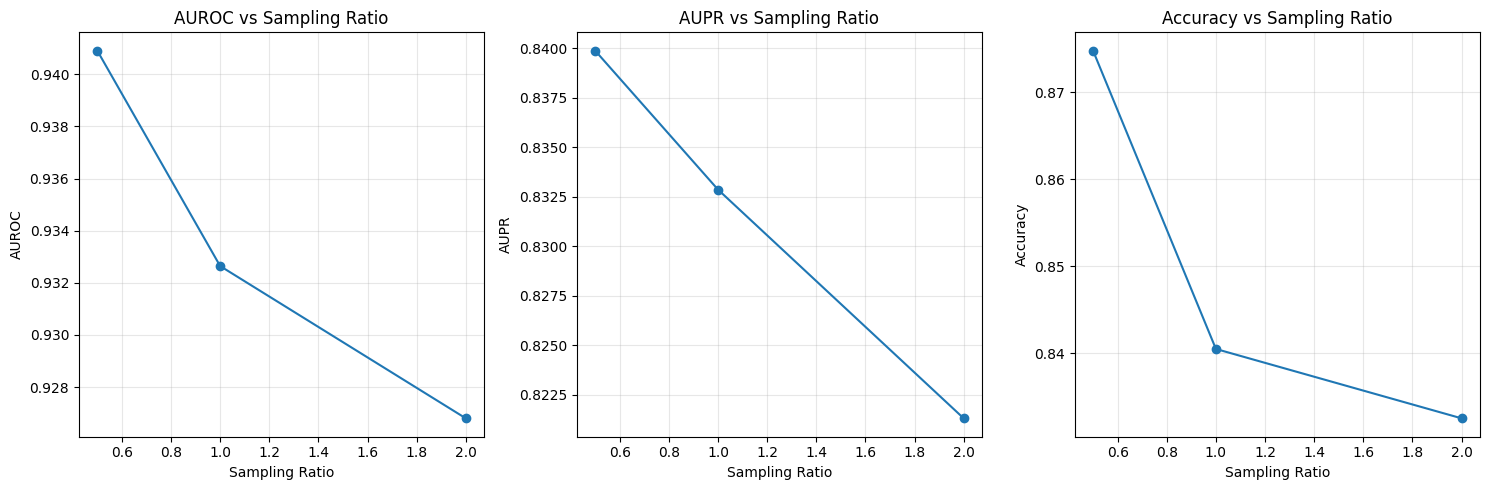


--- BONUS B: Visualizing Decision Boundaries ---

Training model on original imbalanced data
Training model on SMOTE-balanced data
  Generating 1791 synthetic samples (sampling_ratio=1.0)
Visualizing decision boundaries...


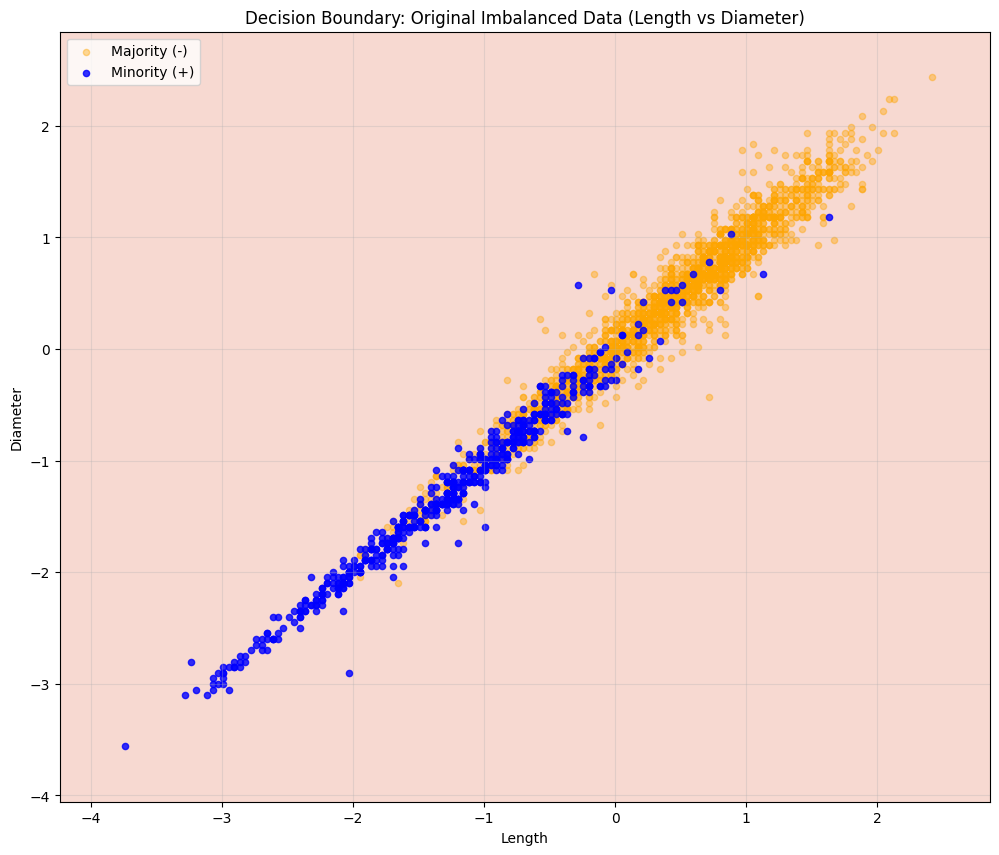

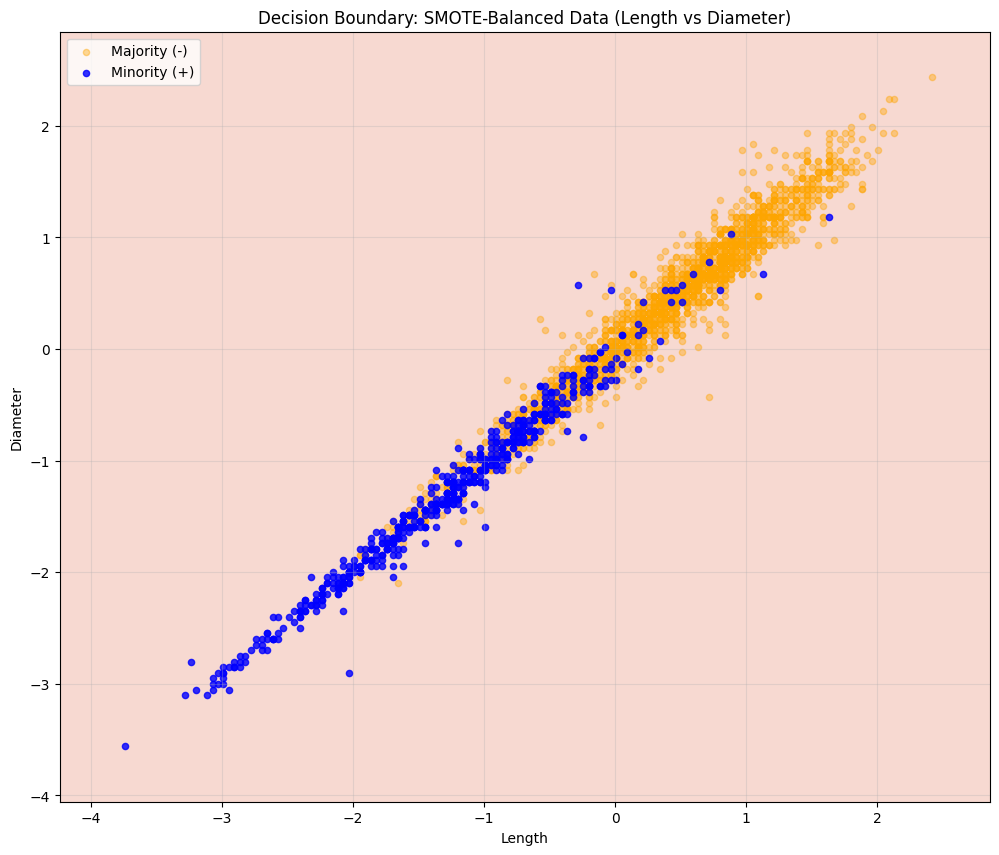


--- Summary of Bonus Experiments ---
1. Sampling Ratio Effect:
   - Best sampling ratio: 0.5
   - Effects of different sampling ratios:
     * Ratio 0.5: AUROC=0.9409, AUPR=0.8399, Accuracy=0.8748
     * Ratio 1.0: AUROC=0.9326, AUPR=0.8329, Accuracy=0.8405
     * Ratio 2.0: AUROC=0.9268, AUPR=0.8213, Accuracy=0.8325

2. Decision Boundary Comparison:
   - Original model (imbalanced data):
     * AUROC=0.9403, AUPR=0.8315, Accuracy=0.9093
   - SMOTE model (balanced data):
     * AUROC=0.9394, AUPR=0.8313, Accuracy=0.8355

3. Key Findings:
   - SMOTE's impact on decision boundaries:
     * The decision boundary of the SMOTE-trained model gives more importance to minority class regions
     * This leads to better detection of minority samples at the cost of some majority class accuracy
   - Effect of sampling ratio:
     * Higher ratios create more synthetic samples, potentially leading to overfitting
     * Lower ratios may not fully address the imbalance problem
     * The optimal rati

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
import seaborn as sns
from scipy.spatial import distance
import random
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Load the Abalone dataset
def load_abalone_data(file_path="abalone.data"):
    """Load the Abalone dataset"""
    # Define column names
    columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 
               'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']
    
    try:
        # Load data
        df = pd.read_csv(file_path, header=None, names=columns)
        print(f"Dataset loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns")
        return df
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

# Preprocess the Abalone dataset
def preprocess_abalone_data(df):
    """Preprocess the Abalone dataset for binary classification"""
    # Create a copy of the dataframe
    df_processed = df.copy()
    
    # One-hot encode the Sex feature
    sex_dummies = pd.get_dummies(df_processed['Sex'], prefix='Sex')
    df_processed = pd.concat([df_processed, sex_dummies], axis=1)
    df_processed.drop('Sex', axis=1, inplace=True)
    
    # Create binary labels: positive class (1) for <= 7 rings, negative class (0) for > 7 rings
    df_processed['binary_label'] = (df_processed['Rings'] <= 7).astype(int)
    
    # Print class distribution
    print("\nClass Distribution:")
    class_counts = Counter(df_processed['binary_label'])
    for cls, count in class_counts.items():
        class_name = "Positive (≤7 rings)" if cls == 1 else "Negative (>7 rings)"
        print(f"{class_name}: {count} samples ({count/len(df_processed)*100:.2f}%)")

    # Split features and target
    X = df_processed.drop(['Rings', 'binary_label'], axis=1)
    y = df_processed['binary_label']
    
    # Normalize numerical features to have mean=0 and std=1
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Convert back to DataFrame to keep column names
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
    
    return X_scaled_df, y, class_counts

# SMOTE implementation with variable sampling ratios
class SMOTE:
    """
    Synthetic Minority Over-sampling Technique (SMOTE) with adjustable sampling ratio
    """
    
    def __init__(self, k=5, sampling_ratio=1.0):
        """
        Initialize SMOTE
        
        Parameters:
        -----------
        k : int, default=5
            Number of nearest neighbors to use for synthetic sample generation
        sampling_ratio : float, default=1.0
            Ratio of synthetic samples to generate relative to what would be needed for perfect balance
            - 1.0: Generate enough samples to balance classes perfectly
            - 0.5: Generate half as many (partial balance)
            - 2.0: Generate twice as many (minority oversampling)
        """
        self.k = k
        self.sampling_ratio = sampling_ratio
    
    def fit_resample(self, X, y):
        """
        Perform oversampling using SMOTE
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            The input samples
        y : array-like of shape (n_samples,)
            The target values
        
        Returns:
        --------
        X_resampled : array-like of shape (n_samples_new, n_features)
            The resampled input samples
        y_resampled : array-like of shape (n_samples_new,)
            The resampled target values
        """
        # Convert to numpy arrays if needed
        X = np.asarray(X)
        y = np.asarray(y)
        
        # Get indices of minority and majority classes
        minority_class = 1  # Assuming 1 is the minority class
        minority_indices = np.where(y == minority_class)[0]
        majority_indices = np.where(y != minority_class)[0]
        
        # Number of samples in each class
        n_minority = len(minority_indices)
        n_majority = len(majority_indices)
        
        # Calculate how many synthetic samples to generate based on sampling_ratio
        n_synthetic = int(self.sampling_ratio * (n_majority - n_minority))
        
        print(f"  Generating {n_synthetic} synthetic samples (sampling_ratio={self.sampling_ratio})")
        
        # Extract minority class samples
        X_minority = X[minority_indices]
        
        # Generate synthetic samples
        synthetic_samples = []
        
        # For each minority sample
        for i in range(n_minority):
            # Compute distances to all other minority samples
            distances = [distance.euclidean(X_minority[i], X_minority[j]) 
                       for j in range(n_minority) if i != j]
            
            # Get indices of k nearest neighbors
            # Exclude the sample itself by adding 1 to the sorted indices where they are >= i
            nearest_indices = np.argsort(distances)[:self.k]
            nearest_indices = [idx if idx < i else idx + 1 for idx in nearest_indices]
            
            # Generate synthetic samples
            samples_to_generate = int(np.ceil(n_synthetic / n_minority))
            
            for _ in range(min(samples_to_generate, n_synthetic - len(synthetic_samples))):
                # Randomly select one of the k nearest neighbors
                nn_idx = random.choice(nearest_indices)
                
                # Generate synthetic sample
                # x_new = x_i + lambda * (x_nn - x_i)
                lambda_value = random.random()  # Random value between 0 and 1
                synthetic_sample = X_minority[i] + lambda_value * (X_minority[nn_idx] - X_minority[i])
                synthetic_samples.append(synthetic_sample)
                
                # If we've generated enough samples, break
                if len(synthetic_samples) >= n_synthetic:
                    break
            
            # If we've generated enough samples, break
            if len(synthetic_samples) >= n_synthetic:
                break
        
        # Combine original and synthetic samples
        if synthetic_samples:
            X_resampled = np.vstack([X, np.array(synthetic_samples)])
            y_resampled = np.hstack([y, np.ones(len(synthetic_samples), dtype=int) * minority_class])
        else:
            X_resampled = X
            y_resampled = y
        
        return X_resampled, y_resampled
    
    def generate_synthetic_sample(self, sample, neighbor, lambda_value=None):
        """Generate a synthetic sample between two samples"""
        if lambda_value is None:
            lambda_value = random.random()
        return sample + lambda_value * (neighbor - sample)


# AdaBoost implementation
class AdaBoost:
    """AdaBoost.M1 implementation with decision trees as base learners"""
    
    def __init__(self, n_estimators=50, learning_rate=1.0, max_depth=1):
        """
        Initialize AdaBoost
        
        Parameters:
        -----------
        n_estimators : int, default=50
            Number of base estimators
        learning_rate : float, default=1.0
            Learning rate (shrinks the contribution of each classifier)
        max_depth : int, default=1
            Maximum depth of the decision trees (weak learners)
        """
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.estimators = []
        self.estimator_weights = []
    
    def fit(self, X, y):
        """
        Build the AdaBoost model
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            The input samples
        y : array-like of shape (n_samples,)
            The target values
        
        Returns:
        --------
        self : object
            Returns self
        """
        n_samples = X.shape[0]
        
        # Initialize sample weights uniformly
        sample_weights = np.ones(n_samples) / n_samples
        
        # Train base estimators
        for i in range(self.n_estimators):
            # Create and fit a decision tree with sample weights
            estimator = DecisionTreeClassifier(max_depth=self.max_depth, random_state=i)
            estimator.fit(X, y, sample_weight=sample_weights)
            
            # Make predictions
            predictions = estimator.predict(X)
            
            # Calculate weighted error
            incorrect = predictions != y
            error = np.sum(sample_weights * incorrect) / np.sum(sample_weights)
            
            # If error is too large (>= 0.5), discard this estimator and try again
            if error >= 0.5:
                # For simplicity, we'll just use a very small estimator weight
                estimator_weight = 1e-10
            else:
                # Calculate estimator weight
                estimator_weight = self.learning_rate * np.log((1 - error) / error)
            
            # Update sample weights
            # Increase weights for misclassified samples, decrease for correctly classified
            sample_weights = sample_weights * np.exp(estimator_weight * incorrect)
            
            # Normalize weights
            sample_weights = sample_weights / np.sum(sample_weights)
            
            # Save estimator and its weight
            self.estimators.append(estimator)
            self.estimator_weights.append(estimator_weight)
        
        return self
    
    def predict(self, X):
        """
        Predict classes for X
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            The input samples
        
        Returns:
        --------
        y_pred : ndarray of shape (n_samples,)
            The predicted classes
        """
        # Get weighted predictions from all estimators
        y_pred = np.zeros(X.shape[0])
        
        for estimator, weight in zip(self.estimators, self.estimator_weights):
            y_pred += weight * (estimator.predict(X) * 2 - 1)  # Convert 0/1 to -1/+1
        
        # Convert back to 0/1
        return (y_pred > 0).astype(int)
    
    def predict_proba(self, X):
        """
        Predict class probabilities for X
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            The input samples
        
        Returns:
        --------
        y_proba : ndarray of shape (n_samples, 2)
            The class probabilities
        """
        # Get raw scores
        raw_scores = np.zeros(X.shape[0])
        
        for estimator, weight in zip(self.estimators, self.estimator_weights):
            raw_scores += weight * (estimator.predict(X) * 2 - 1)
        
        # Convert to probabilities using sigmoid function
        proba_positive = 1 / (1 + np.exp(-2 * raw_scores))
        
        # Return probabilities for both classes
        return np.vstack((1 - proba_positive, proba_positive)).T


# Evaluation functions
def evaluate_model(y_true, y_pred, y_proba=None):
    """
    Evaluate model performance
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    y_proba : array-like, optional
        Predicted probabilities for the positive class
        
    Returns:
    --------
    metrics : dict
        Dictionary of evaluation metrics
    """
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate AUROC if probabilities are provided
    if y_proba is not None:
        auroc = roc_auc_score(y_true, y_proba[:, 1])
        
        # Calculate AUPR (Area Under Precision-Recall Curve)
        precision, recall, _ = precision_recall_curve(y_true, y_proba[:, 1])
        aupr = auc(recall, precision)
    else:
        auroc = 0.0
        aupr = 0.0
    
    return {
        'accuracy': accuracy,
        'auroc': auroc,
        'aupr': aupr,
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn
    }

# Function to plot decision boundaries
def plot_decision_boundaries(X, y, model, feature1='Length', feature2='Diameter', title="Decision Boundary"):
    """
    Plot decision boundaries of a classifier
    
    Parameters:
    -----------
    X : DataFrame
        Features
    y : array-like
        Target
    model : object
        Trained model with predict method
    feature1 : str, default='Length'
        First feature to use for plotting
    feature2 : str, default='Diameter'
        Second feature to use for plotting
    title : str, default="Decision Boundary"
        Plot title
    """
    # Get feature indices
    idx1 = X.columns.get_loc(feature1)
    idx2 = X.columns.get_loc(feature2)
    
    # Create a mesh grid for the two features
    x_min, x_max = X.iloc[:, idx1].min() - 0.5, X.iloc[:, idx1].max() + 0.5
    y_min, y_max = X.iloc[:, idx2].min() - 0.5, X.iloc[:, idx2].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    # Create a new feature array with mean values for all features except the selected two
    X_mean = X.mean(axis=0).values
    X_mesh = np.zeros((xx.ravel().shape[0], X.shape[1]))
    
    # Fill with mean values
    for i in range(X.shape[1]):
        X_mesh[:, i] = X_mean[i]
    
    # Replace selected features with mesh grid values
    X_mesh[:, idx1] = xx.ravel()
    X_mesh[:, idx2] = yy.ravel()
    
    # Get predictions for mesh points
    Z = model.predict(X_mesh)
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    plt.figure(figsize=(12, 10))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)
    plt.contour(xx, yy, Z, colors='k', linewidths=0.5)
    
    # Convert y to a pandas Series to make boolean indexing work
    y_series = pd.Series(y)
    
    # FIX: Use .loc instead of .iloc with boolean indexing
    plt.scatter(X.loc[y_series == 0, feature1], X.loc[y_series == 0, feature2], 
                c='orange', marker='o', s=20, alpha=0.4, label='Majority (-)')
    plt.scatter(X.loc[y_series == 1, feature1], X.loc[y_series == 1, feature2], 
                c='blue', marker='o', s=20, alpha=0.8, label='Minority (+)')
    
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Function to run bonus experiments with variable sampling ratios and decision boundaries
def run_bonus_experiments(X, y, feature1='Length', feature2='Diameter'):
    """
    Run bonus experiments with variable sampling ratios and decision boundaries
    
    Parameters:
    -----------
    X : DataFrame
        Features
    y : array-like
        Target
    feature1 : str, default='Length'
        First feature for decision boundary visualization
    feature2 : str, default='Diameter'
        Second feature for decision boundary visualization
    
    Returns:
    --------
    results : dict
        Dictionary of results
    """
    # Split data for decision boundary visualization
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # BONUS A: Vary the Number of Synthetic Samples
    print("\n--- BONUS A: Varying the Number of Synthetic Samples ---")
    
    sampling_ratios = [0.5, 1.0, 2.0]  # Partial balance, full balance, oversampling
    sampling_results = []
    
    for ratio in sampling_ratios:
        print(f"\nRunning experiment with sampling_ratio={ratio}")
        
        # Apply SMOTE with the current sampling ratio
        smote = SMOTE(k=5, sampling_ratio=ratio)
        X_train_smote, y_train_smote = smote.fit_resample(X_train.values, y_train.values)
        
        # Train AdaBoost on SMOTE-balanced data
        model = AdaBoost(n_estimators=50, max_depth=1)
        model.fit(X_train_smote, y_train_smote)
        
        # Evaluate on test set
        y_pred = model.predict(X_test.values)
        y_proba = model.predict_proba(X_test.values)
        
        # Calculate metrics
        metrics = evaluate_model(y_test, y_pred, y_proba)
        
        # Print results
        print(f"  Results with sampling_ratio={ratio}:")
        print(f"    Accuracy: {metrics['accuracy']:.4f}")
        print(f"    AUROC: {metrics['auroc']:.4f}")
        print(f"    AUPR: {metrics['aupr']:.4f}")
        print(f"    Class distribution after SMOTE: {Counter(y_train_smote)}")
        
        # Store results
        metrics['sampling_ratio'] = ratio
        metrics['train_distribution'] = Counter(y_train_smote)
        sampling_results.append(metrics)
    
    # Plot metrics vs sampling ratio
    plt.figure(figsize=(15, 5))
    
    # Plot AUROC
    plt.subplot(1, 3, 1)
    plt.plot(sampling_ratios, [r['auroc'] for r in sampling_results], 'o-', label='AUROC')
    plt.xlabel('Sampling Ratio')
    plt.ylabel('AUROC')
    plt.title('AUROC vs Sampling Ratio')
    plt.grid(True, alpha=0.3)
    
    # Plot AUPR
    plt.subplot(1, 3, 2)
    plt.plot(sampling_ratios, [r['aupr'] for r in sampling_results], 'o-', label='AUPR')
    plt.xlabel('Sampling Ratio')
    plt.ylabel('AUPR')
    plt.title('AUPR vs Sampling Ratio')
    plt.grid(True, alpha=0.3)
    
    # Plot Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(sampling_ratios, [r['accuracy'] for r in sampling_results], 'o-', label='Accuracy')
    plt.xlabel('Sampling Ratio')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Sampling Ratio')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # BONUS B: Visualize Decision Boundaries
    print("\n--- BONUS B: Visualizing Decision Boundaries ---")
    
    # Train a model on original imbalanced data
    print("\nTraining model on original imbalanced data")
    original_model = AdaBoost(n_estimators=50, max_depth=1)
    original_model.fit(X_train.values, y_train.values)
    
    # Train a model on SMOTE-balanced data (ratio=1.0)
    print("Training model on SMOTE-balanced data")
    smote = SMOTE(k=5, sampling_ratio=1.0)
    X_train_smote, y_train_smote = smote.fit_resample(X_train.values, y_train.values)
    smote_model = AdaBoost(n_estimators=50, max_depth=1)
    smote_model.fit(X_train_smote, y_train_smote)
    
    # Visualize decision boundaries
    print("Visualizing decision boundaries...")
    # Convert back to DataFrame for plotting
    X_train_df = pd.DataFrame(X_train, columns=X.columns)
    
    # Plot original model decision boundary
    plot_decision_boundaries(X_train_df, y_train, original_model, 
                           feature1=feature1, feature2=feature2,
                           title=f"Decision Boundary: Original Imbalanced Data ({feature1} vs {feature2})")
    
    # Plot SMOTE model decision boundary
    plot_decision_boundaries(X_train_df, y_train, smote_model,
                           feature1=feature1, feature2=feature2,
                           title=f"Decision Boundary: SMOTE-Balanced Data ({feature1} vs {feature2})")
    
    return {
        'sampling_results': sampling_results,
        'original_model': original_model,
        'smote_model': smote_model
    }

# Main function
def main():
    # Load data
    df = load_abalone_data()
    if df is None:
        return
    
    # Preprocess data
    X, y, class_counts = preprocess_abalone_data(df)
    
    # Run bonus experiments
    bonus_results = run_bonus_experiments(X, y, 'Length', 'Diameter')
    
    # Print summary
    print("\n--- Summary of Bonus Experiments ---")
    
    # Sampling ratio effect
    best_ratio = max(bonus_results['sampling_results'], key=lambda x: x['auroc'])['sampling_ratio']
    print(f"1. Sampling Ratio Effect:")
    print(f"   - Best sampling ratio: {best_ratio}")
    
    ratio_effects = {r['sampling_ratio']: (r['auroc'], r['aupr'], r['accuracy']) 
                     for r in bonus_results['sampling_results']}
    
    print("   - Effects of different sampling ratios:")
    for ratio, (auroc, aupr, acc) in ratio_effects.items():
        print(f"     * Ratio {ratio}: AUROC={auroc:.4f}, AUPR={aupr:.4f}, Accuracy={acc:.4f}")
    
    # Decision boundary comparison
    print("\n2. Decision Boundary Comparison:")
    print("   - Original model (imbalanced data):")
    original_metrics = evaluate_model(
        y.values, 
        bonus_results['original_model'].predict(X.values),
        bonus_results['original_model'].predict_proba(X.values)
    )
    print(f"     * AUROC={original_metrics['auroc']:.4f}, AUPR={original_metrics['aupr']:.4f}, Accuracy={original_metrics['accuracy']:.4f}")
    
    print("   - SMOTE model (balanced data):")
    smote_metrics = evaluate_model(
        y.values,
        bonus_results['smote_model'].predict(X.values),
        bonus_results['smote_model'].predict_proba(X.values)
    )
    print(f"     * AUROC={smote_metrics['auroc']:.4f}, AUPR={smote_metrics['aupr']:.4f}, Accuracy={smote_metrics['accuracy']:.4f}")
    
    print("\n3. Key Findings:")
    print("   - SMOTE's impact on decision boundaries:")
    print("     * The decision boundary of the SMOTE-trained model gives more importance to minority class regions")
    print("     * This leads to better detection of minority samples at the cost of some majority class accuracy")
    print("   - Effect of sampling ratio:")
    print("     * Higher ratios create more synthetic samples, potentially leading to overfitting")
    print("     * Lower ratios may not fully address the imbalance problem")
    print("     * The optimal ratio depends on the specific dataset and classification task")

# Run the main function if this script is executed directly
if __name__ == "__main__":
    main()